In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
from datetime import date
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud

%matplotlib inline

D:\Anaconda3\envs\Udacity\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
anime = pd.read_csv('Animelist.csv')

In [3]:
users = pd.read_csv('users_cleaned.csv')

In [4]:
anime_list = pd.read_csv('animelists_filtered.csv')

# Sumario:

### Limpeza dos dados:


- #### Limpeza da Tabela users
- #### Limpeza da Tabela anime_list
- #### Limpeza da Tabela anime

     
     
### Implementação do Modelo para Filtro Demográfico, Anime


- #### Preparação da Tabela para o Modelo

- #### Implementar modelo 1 - GMM - Gaussiam Mixture:
         - Descobrir melhor número de Klusters
         - Implementar Modelo
- #### Implementar modelo 2 - KMeans:
         - Descobrir melhor número de Klusters
         - Implementar Modelo 
- #### Recolher informações:
         - Escolher melhor modelo
         - Retirar Informações de cada Kluster
         
         
### Implementação do Modelo para Filtro Colaborativo, Users


- #### Preparação da Tabela para o Modelo

- #### Implementar modelo 1 - GMM - Gaussiam Mixture:
         - Descobrir melhor número de Klusters
         - Implementar Modelo
- #### Implementar modelo 2 - KMeans:
         - Descobrir melhor número de Klusters
         - Implementar Modelo 
- #### Recolher informações:
         - Escolher melhor modelo
         - Retirar Informações de cada Kluster         
         

# Limpeza dos dados:

### Tabela Users
    - Foram retiradas dados nulos
    - Foram retiradas usuários que deram notas a menos de 20 animes e mais de 300;
    - Coluna birth_date alterada para age, onde possui a idade do usuário
    - Colunas que não irão ser utilizadas no modelo foram retiradas.
        - A coluna location, embora eu queira usar, ela não possui dados confiaveis, pois o usuário pode preencher com qualquer string.


In [5]:
users.head()

username  user_id  user_watching  user_completed  user_onhold  \
0        karthiga  2255153              3              49            1   
1       Damonashu    37326             45             195           27   
2           bskai   228342             25             414            2   
3  terune_uzumaki   327311              5               5            0   
4           Bas_G  5015094             35             114            6   

   user_dropped  user_plantowatch  user_days_spent_watching  gender  \
0             0                 0                 55.091667  Female   
1            25                59                 82.574306    Male   
2             5                11                159.483333    Male   
3             0                 0                 11.394444  Female   
4            20               175                 30.458333    Male   

              location           birth_date  access_rank            join_date  \
0      Chennai, India   1990-04-29 00:00:00          NaN  2013-03-03 00:00:00   
1     Detroit,Michigan  1991-08-01 00:00:00          NaN  2008-02-13 00:00:00   
2      Nayarit, Mexico  1990-12-14 00:00:00          NaN  2009-08-31 00:00:00   
3    Malaysia, Kuantan  1998-08-24 00:00:00          NaN  2010-05-10 00:00:00   
4  Nijmegen, Nederland  1999-10-24 00:00:00          NaN  2015-11-26 00:00:00   

           last_online  stats_mean_score  stats_rewatched  stats_episodes  
0  2014-02-04 01:32:00              7.43              0.0            3391  
1  2017-07-10 06:52:54              6.15              6.0            4903  
2  2014-05-12 16:35:00              8.27              1.0            9701  
3  2012-10-18 19:06:00              9.70              6.0             697  
4  2018-05-10 20:53:37              7.86              0.0            1847

In [6]:
users.isnull().sum()

username                         1
user_id                          0
user_watching                    0
user_completed                   0
user_onhold                      0
user_dropped                     0
user_plantowatch                 0
user_days_spent_watching         0
gender                           0
location                         5
birth_date                       0
access_rank                 108711
join_date                        0
last_online                      0
stats_mean_score                 0
stats_rewatched                  0
stats_episodes                   0
dtype: int64

In [7]:
users = users.drop(['access_rank'], axis= 1)

In [8]:
users = users.dropna()

In [9]:
users['username'].count()

108705

In [10]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))


In [11]:
users['users_age'] = pd.to_datetime(users['birth_date'])
users['age'] = users['users_age'].apply(calculate_age)
users = users.drop(['users_age', 'birth_date'], axis= 1)

In [12]:
users = users.drop(['user_watching' , 'user_completed', 'user_onhold', 'user_dropped', 
                   'user_plantowatch', 'user_days_spent_watching', 'join_date',
                   'last_online', 'stats_rewatched', 'stats_episodes','location'], axis= 1)

In [13]:
users.head(10)

username  user_id  gender  stats_mean_score  age
0        karthiga  2255153  Female              7.43   28
1       Damonashu    37326    Male              6.15   27
2           bskai   228342    Male              8.27   28
3  terune_uzumaki   327311  Female              9.70   20
4           Bas_G  5015094    Male              7.86   19
5        HimeAria  3129315  Female              8.23   22
6     Skallington   326733    Male             10.00   27
7          Slimak    61677    Male              7.77   31
8         Elysiun  5927342    Male              7.40   34
9      jimothy000    47167    Male              9.33   23

D:\Anaconda3\envs\Udacity\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


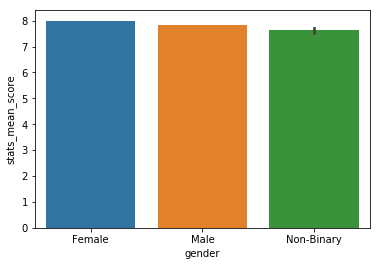

In [24]:
sns.barplot(y=users['stats_mean_score'], x =users['gender'],  estimator = np.median )

D:\Anaconda3\envs\Udacity\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


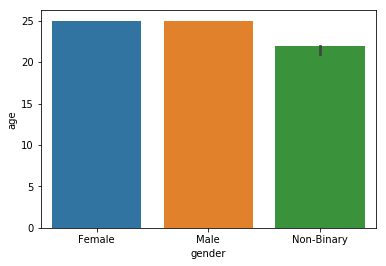

In [23]:
sns.barplot(y=users['age'], x =users['gender'], estimator = np.median )

D:\Anaconda3\envs\Udacity\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


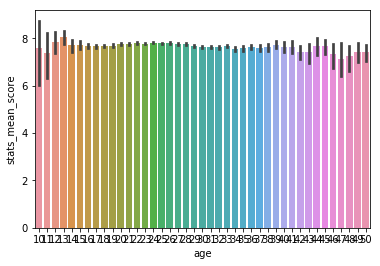

In [27]:
sns.barplot(y=users['stats_mean_score'], x =users['age'] )

# Limpeza dos dados:

### Tabela Anime_list
    - Foram retiradas dados nulos
    - Foram retiradas usuários que deram notas a menos de 20 animes e mais de 300;
    - Usuários que assistiram 0 episodios;
    - Colunas que não irão ser utilizadas no modelo foram retiradas.


-  Devido a grande quantidade de dados, erros de memória eram recorrentes, então foi necessário utilizar a tabela já previamente limpa;

In [28]:
anime_list.head()

username  anime_id  my_watched_episodes my_start_date  \
0          karthiga        21                  586    0000-00-00   
1  RedvelvetDaisuki        21                    0    0000-00-00   
2         Damonashu        21                  418    0000-00-00   
3             bskai        21                   75    0000-00-00   
4            Slimak        21                  834    0000-00-00   

  my_finish_date  my_score  my_status  my_rewatching  my_rewatching_ep  \
0     0000-00-00         9          1            NaN                 0   
1     0000-00-00         0          3            0.0                 0   
2     0000-00-00        10          1            0.0                 0   
3     0000-00-00         8          1            0.0                 0   
4     0000-00-00        10          1            0.0                 0   

   my_last_updated my_tags  
0       1362307973     NaN  
1       1355480701     NaN  
2       1254296345     NaN  
3       1276637483     NaN  
4       1525176321     NaN

In [30]:
anime_list = anime_list[anime_list['username'].isin(users['username'])]

In [31]:
anime_list.isnull().sum()

username                      0
anime_id                      0
my_watched_episodes           0
my_start_date                 0
my_finish_date                0
my_score                      0
my_status                     0
my_rewatching           7283788
my_rewatching_ep              0
my_last_updated               0
my_tags                31547906
dtype: int64

In [32]:
anime_list.my_score.describe()

count    3.370052e+07
mean     4.555648e+00
std      3.923876e+00
min      0.000000e+00
25%      0.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: my_score, dtype: float64

In [33]:
anime_list[anime_list['my_watched_episodes']==0].my_watched_episodes.count()

9075882

In [34]:
anime_list[anime_list['my_watched_episodes']==0].my_score.describe()

count    9.075882e+06
mean     1.945062e-01
std      1.236510e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: my_score, dtype: float64

In [35]:
anime_list = anime_list.drop(anime_list[anime_list.my_watched_episodes == 0].index)
anime_list = anime_list[anime_list['username'].notnull()]

In [36]:
add_title_anime_id = pd.DataFrame(
    {'anime_id': anime['anime_id'],
     'title': anime['title']  
    })


In [37]:
add_username_user_id = pd.DataFrame(
    {'user_id': users['user_id'],
     'username': users['username']  
    })

In [38]:
anime_list['username'].count() 

24624641

In [39]:
anime_list = pd.merge(anime_list,add_title_anime_id,on=['anime_id','anime_id'])

In [40]:
anime_list = pd.merge(anime_list,add_username_user_id,on=['username','username'])

In [41]:
anime_list['username'].count() 

24624641

- ### Devido a grande quantidade de dados nesta tabela, foi removido os +-20% usuários que mais deram score a um anime. Estava onerando o computador, causando constantes erros de memória e/ ou tornando o processamento do trabalho em mais de 1hora. 

In [42]:
users_reduced = anime_list.groupby('username')['username'].count() < 20
users_reduced_2 = anime_list.groupby('username')['username'].count() > 300
size = len(anime_list.groupby('username'))
drop_users = []
for i in range(0,size) :
    if users_reduced[i] == True:
        drop_users.append(users_reduced.index[i])        
    elif users_reduced_2[i] == True:
        drop_users.append(users_reduced_2.index[i])        


In [43]:
users = users[~users['username'].isin(drop_users)]

In [44]:
anime_list = anime_list[~anime_list['username'].isin(drop_users)]

In [45]:
anime_list['username'].count()

9389229

In [46]:
aa = anime_list.groupby('username').count()
aa.anime_id.describe()

count    71929.000000
mean       130.534680
std         76.874719
min         20.000000
25%         65.000000
50%        118.000000
75%        188.000000
max        300.000000
Name: anime_id, dtype: float64

In [47]:
anime_list = anime_list.drop(['my_start_date', 'my_finish_date', 'my_rewatching',
                             'my_rewatching_ep', 'my_last_updated', 'my_tags',
                              'my_status', 'my_watched_episodes'], axis = 1)

In [48]:
anime_list.head()

username  anime_id  my_score          title  user_id
0  karthiga        21         9      One Piece  2255153
1  karthiga        59         7        Chobits  2255153
2  karthiga        74         7   Gakuen Alice  2255153
3  karthiga       120         7  Fruits Basket  2255153
4  karthiga       178         7   Ultra Maniac  2255153

### Tabela anime

    - Foram retiradas dados nulos
        - Retirar Gender NaN
        - Retirar Rating NaN
        - Retirar Type = Unknown
    - Foram retiradas animes que, na época, ainda não tinha lançado;
    - Foram retiradas animes que receberam notas de 0 pessoas.
    - Devido ao grande número de dados nulos de producer e studio, não será utilizado as colunas no modelo, pois a outra opção seria retiras os dados nulos que seria 40% da tabela a menos.  
    - Colunas que não irão ser utilizadas no modelo foram retiradas.


In [49]:
anime.head()

anime_id                title              title_english title_japanese  \
0     11013        Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
1      2104     Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
2      5262   Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
3       721        Princess Tutu              Princess Tutu      プリンセスチュチュ   
4     12365  Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                  title_synonyms  \
0                                Youko x Boku SS   
1                           The Inland Sea Bride   
2  Shugo Chara Ninenme, Shugo Chara! Second Year   
3                                            NaN   
4                               Bakuman Season 3   

                                           image_url type    source  episodes  \
0  https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga        12   
1  https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga        26   
2  https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga        51   
3  https://myanimelist.cdn-dena.com/images/anime/...   TV  Original        38   
4  https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga        25   

            status                        ...                          \
0  Finished Airing                        ...                           
1  Finished Airing                        ...                           
2  Finished Airing                        ...                           
3  Finished Airing                        ...                           
4  Finished Airing                        ...                           

                                          background    premiered  \
0  Inu x Boku SS was licensed by Sentai Filmworks...  Winter 2012   
1                                                NaN  Spring 2007   
2                                                NaN    Fall 2008   
3  Princess Tutu aired in two parts. The first pa...  Summer 2002   
4                                                NaN    Fall 2012   

            broadcast                                            related  \
0  Fridays at Unknown  {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
1             Unknown  {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
2             Unknown  {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
3  Fridays at Unknown  {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
4             Unknown  {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                            producer          licensor  \
0  Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
1                  TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
2                                    TV Tokyo, Sotsu               NaN   
3                 Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
4                                      NHK, Shueisha               NaN   

             studio                                     genre  \
0  David Production    Comedy, Supernatural, Romance, Shounen   
1             Gonzo  Comedy, Parody, Romance, School, Shounen   
2         Satelight             Comedy, Magic, School, Shoujo   
3    Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
4         J.C.Staff           Comedy, Drama, Romance, Shounen   

                                       opening_theme  \
0                              ['"Nirvana" by MUCC']   
1                 ['"Romantic summer" by SUN&LUNAR']   
2  ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
3             ['"Morning Grace" by Ritsuko Okazaki']   
4  ['#1: "Moshimo no Hanashi (もしもの話)" by nano.RIP...   

                                        ending_theme  
0  ['#1: "Nirvana" by MUCC (eps 1, 11-12)', '#2: ...  
1  ['#1: "Ashita e no Hikari (明日への光)" by Asuka Hi...  
2  ['#1: "Rottara Rottara (ロッタラ ロッタラ)" by Buono! ...  
3  ['"Watashi No Ai Wa Chiisai

In [50]:
anime.describe()

anime_id      episodes         score     scored_by          rank  \
count  14478.000000  14478.000000  14478.000000  1.447800e+04  12904.000000   
mean   17377.229866     11.308399      6.142482  1.146003e+04   6439.065406   
std    13165.315011     43.443451      1.463981  4.310519e+04   3720.227608   
min        1.000000      0.000000      0.000000  0.000000e+00      0.000000   
25%     4389.250000      1.000000      5.550000  4.600000e+01   3216.250000   
50%    15135.000000      1.000000      6.370000  5.010000e+02   6441.500000   
75%    31146.500000     12.000000      7.060000  3.941500e+03   9664.000000   
max    37916.000000   1818.000000     10.000000  1.009477e+06  12919.000000   

         popularity       members      favorites  
count  14478.000000  1.447800e+04   14478.000000  
mean    7220.259566  2.296640e+04     311.649606  
std     4170.080564  7.498136e+04    2615.554211  
min        0.000000  0.000000e+00       0.000000  
25%     3611.500000  2.450000e+02       0.000000  
50%     7225.500000  1.679500e+03       2.000000  
75%    10827.750000  1.037900e+04      23.000000  
max    14487.000000  1.456378e+06  106895.000000

In [51]:
anime.isnull().sum()

anime_id              0
title                 0
title_english      8754
title_japanese       35
title_synonyms     5541
image_url            96
type                  0
source                0
episodes              0
status                0
airing                0
aired_string          0
aired                 0
duration              0
rating                0
score                 0
scored_by             0
rank               1574
popularity            0
members               0
favorites             0
background        13421
premiered         10382
broadcast         10207
related               0
producer           6190
licensor          11105
studio             5934
genre                64
opening_theme         0
ending_theme          0
dtype: int64

In [52]:
anime = anime[anime['genre'].notnull()]
anime = anime.drop(['studio', 'producer'], axis=1)

In [53]:
not_aired = anime[anime['status'] == 'Not yet aired']
not_aired

anime_id                                              title  \
55        33185           Peace Maker Kurogane Movie 1: Omou Michi   
76        37447                                    Karakuri Circus   
109       36951                            Yuu☆Yuu☆Hakusho Special   
143       37711                                     Koi to Uso OVA   
145       37435                                    Carol & Tuesday   
187       35759                                 Sidonia no Kishi 3   
229       34779                     Ar:pieL - 6-seosgaeui Unmyeong   
334       35503                      Shoujo☆Kageki Revue Starlight   
387       37208                                      Mo Dao Zu Shi   
458       37509                                           W&#039;z   
511       37651     Fate/Extra: Last Encore - Irusterias Tendouron   
639       33248             K: Seven Stories Movie 1 - R:B - Blaze   
671       37106                                        Kori no Koe   
784       37831  Sword Art Online Alternative: Gun Gale Online ...   
864       37779                              Yakusoku no Neverland   
894       35424  Donten ni Warau Gaiden: Shukumei, Soutou no Fuuma   
930       37303  K: Seven Stories Movie 2 - Side:Blue - Tenrou ...   
943       36699                          Kimitachi wa Dou Ikiru ka   
947       36474                      Sword Art Online: Alicization   
988       37449                               Strike the Blood III   
1042      36858                                Garo: Uzusumizakura   
1181      20471                                           Aoki Uru   
1282      34440        Code Geass: Hangyaku no Lelouch III - Oudou   
1298      36587                   Granblue Fantasy The Animation 2   
1310      33852                                  Mekakucity Reload   
1396      35252                                    Hatena☆Illusion   
1409      37396                                        Shikioriori   
1410      37597            Dakaretai Otoko 1-i ni Odosarete Imasu.   
1581      37438                                            Ingress   
1635      37555                         Hangyakusei Million Arthur   
...         ...                                                ...   
14074     33438                            Force of Will the Movie   
14076     37599                                   Magatsu Wahrheit   
14106     37870                             BanG Dream! 3rd Season   
14108     35213                               Kai Feng Kidan Movie   
14184     37873                              BanG Dream! Garu☆PICO   
14227     37286                                  It&#039;s My Life   
14272     37885                                 Dragon Ball Heroes   
14273     37916              Uma Musume: Pretty Derby (TV) Special   
14275     37890                Oshi ga Budoukan Ittekuretara Shinu   
14283     37839   Boku wa Robot-goshi no Kimi ni Koi wo Suru Movie   
14284     37760                                          Mecha-ude   
14289     37472                          Lalala Lala-chan Season 4   
14290     37340                                 Venus Blood: Brave   
14291     37328                 Oshiete Fairilu: Mahou no Pendulum   
14296     37117                               Bakutsuri Bar Hunter   
14307     37365                           Oshie to Tabi Suru Otoko   
14358     37884                                   Golden Kamuy OVA   
14368     37893                                      Yami Shibai 6   
14371     37904                                         Meshinuma.   
14374     37887                                      Huan Jie Wang   
14376     37501           Hug tto! Precure♡Futari wa Precure Movie   
14390     37364                         Kekkai Sensen & Beyond OVA   
14392     37905                                        To the Moon   
14404     37827                                        Neko Kikaku   
14410     37902                     One Piece: Episode of Sorajima   
14414     37662  

In [54]:
not_aired['anime_id'].count()

328

In [55]:
anime[anime['rating'] == 'None']['anime_id'].count()

531

In [56]:
anime[anime['type'] == 'Unknown']['anime_id'].count()

29

In [57]:
anime[anime['source'] == 'Unknown']['anime_id'].count()

4179

In [58]:
anime = anime[anime['rating'] != 'None']
anime = anime[anime['type'] != 'Unknown']
anime = anime[anime['source'] != 'Unknown']
anime = anime[anime['status'] != 'Not yet aired']


In [59]:
anime = anime.drop(['title_english', 'title_japanese', 'title_synonyms', 'image_url','broadcast',
            'related', 'licensor', 'opening_theme', 'ending_theme', 'background', 'premiered',
            'aired_string', 'aired','airing', 'duration','rank','popularity', 'status'], axis=1)

In [60]:
anime.describe()

anime_id     episodes        score     scored_by       members  \
count   9794.000000  9794.000000  9794.000000  9.794000e+03  9.794000e+03   
mean   17789.798448    11.433020     6.422912  1.656367e+04  3.281781e+04   
std    13834.784511    37.984858     1.193983  5.160772e+04  8.936438e+04   
min        1.000000     0.000000     0.000000  0.000000e+00  9.000000e+00   
25%     3737.250000     1.000000     5.770000  1.200000e+02  4.740000e+02   
50%    15138.000000     2.000000     6.610000  1.271500e+03  3.575000e+03   
75%    32818.750000    12.000000     7.260000  9.226250e+03  2.189900e+04   
max    37896.000000  1818.000000    10.000000  1.009477e+06  1.456378e+06   

           favorites  
count    9794.000000  
mean      458.312232  
std      3169.616376  
min         0.000000  
25%         0.000000  
50%         7.000000  
75%        58.000000  
max    106895.000000

In [62]:
anime["genre"] = anime["genre"].apply(lambda x: x.replace(' ', ''))

In [63]:
anime.head()

anime_id                title type    source  episodes  \
0     11013        Inu x Boku SS   TV     Manga        12   
1      2104     Seto no Hanayome   TV     Manga        26   
2      5262   Shugo Chara!! Doki   TV     Manga        51   
3       721        Princess Tutu   TV  Original        38   
4     12365  Bakuman. 3rd Season   TV     Manga        25   

                      rating  score  scored_by  members  favorites  \
0  PG-13 - Teens 13 or older   7.63     139250   283882       2809   
1  PG-13 - Teens 13 or older   7.89      91206   204003       2579   
2              PG - Children   7.55      37129    70127        802   
3  PG-13 - Teens 13 or older   8.21      36501    93312       3344   
4  PG-13 - Teens 13 or older   8.67     107767   182765       2082   

                                  genre  
0   Comedy,Supernatural,Romance,Shounen  
1  Comedy,Parody,Romance,School,Shounen  
2            Comedy,Magic,School,Shoujo  
3    Comedy,Drama,Magic,Romance,Fantasy  
4          Comedy,Drama,Romance,Shounen

D:\Anaconda3\envs\Udacity\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


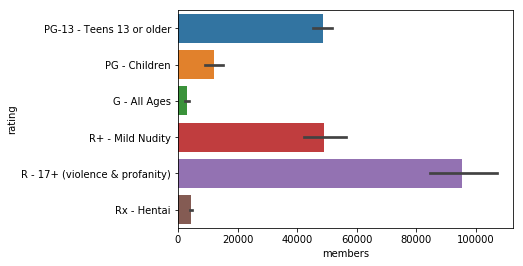

In [51]:
sns.barplot(y=anime['rating'], x =anime['members'])

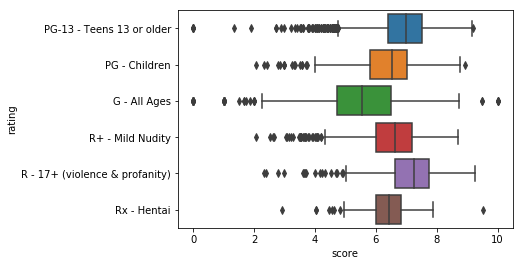

In [66]:
sns.boxplot(data=anime,x='score',y='rating')

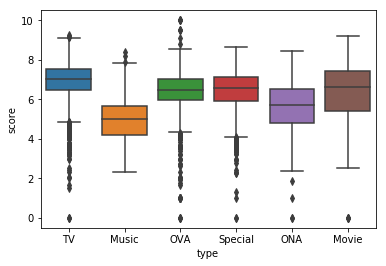

In [52]:
sns.boxplot(data=anime,x='type',y='score')

D:\Anaconda3\envs\Udacity\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


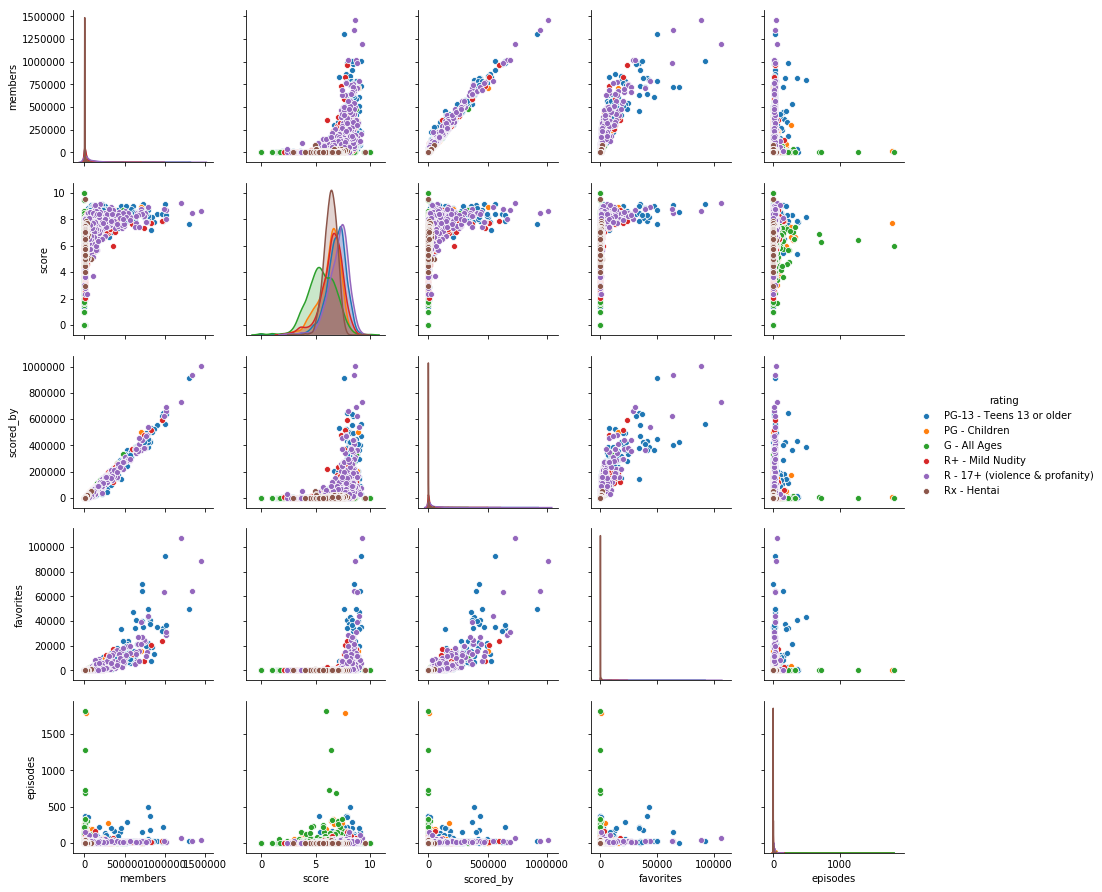

In [53]:
sns.pairplot(data=anime[['rating','members','score','scored_by', 'favorites', 'episodes']],hue='rating')

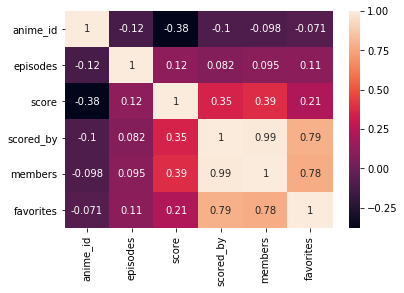

In [54]:
sns.heatmap(anime.corr(),annot=True)

# Implementação do Modelo para Filtro Demográfico, Anime

- Filtro Demográfico
    - Oferece uma recomendação generalizada baseada no genêro e/ou popularidade.

- ### Preparação da Tabela para o Modelo


- Não podemos usar o np.log pois criaria valores NaN, impossibilitando o PCA. Então estamos usando o MinMaxScaler.
- PCA = 3 para podermos visualizar os resultados
- Criação das colunas "dummies" para podermos utilizar as colunas classificatórias no modelo.

In [55]:
anime.head()

anime_id                title type    source  episodes  \
0     11013        Inu x Boku SS   TV     Manga        12   
1      2104     Seto no Hanayome   TV     Manga        26   
2      5262   Shugo Chara!! Doki   TV     Manga        51   
3       721        Princess Tutu   TV  Original        38   
4     12365  Bakuman. 3rd Season   TV     Manga        25   

                      rating  score  scored_by  members  favorites  \
0  PG-13 - Teens 13 or older   7.63     139250   283882       2809   
1  PG-13 - Teens 13 or older   7.89      91206   204003       2579   
2              PG - Children   7.55      37129    70127        802   
3  PG-13 - Teens 13 or older   8.21      36501    93312       3344   
4  PG-13 - Teens 13 or older   8.67     107767   182765       2082   

                                  genre  
0   Comedy,Supernatural,Romance,Shounen  
1  Comedy,Parody,Romance,School,Shounen  
2            Comedy,Magic,School,Shoujo  
3    Comedy,Drama,Magic,Romance,Fantasy  
4          Comedy,Drama,Romance,Shounen

In [56]:
anime["genre"] = anime["genre"].apply(lambda x: x.replace(' ', ''))
anime_features = pd.concat([anime["genre"].str.get_dummies(sep=",").replace(' ', ''),
                            pd.get_dummies(anime[["type"]]),
                            pd.get_dummies(anime[["source"]]),
                            pd.get_dummies(anime[["rating"]]),
                            anime[["score"]],anime[["scored_by"]],anime[["favorites"]],
                            anime[["members"]],anime["episodes"]],axis=1)


anime_features.head()

Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  Fantasy  \
0       0          0     0       1         0       0      0      0        0   
1       0          0     0       1         0       0      0      0        0   
2       0          0     0       1         0       0      0      0        0   
3       0          0     0       1         0       0      1      0        1   
4       0          0     0       1         0       0      1      0        0   

   Game    ...     rating_PG - Children  rating_PG-13 - Teens 13 or older  \
0     0    ...                        0                                 1   
1     0    ...                        0                                 1   
2     0    ...                        1                                 0   
3     0    ...                        0                                 1   
4     0    ...                        0                                 1   

   rating_R - 17+ (violence & profanity)  rating_R+ - Mild Nudity  \
0                                      0                        0   
1                                      0                        0   
2                                      0                        0   
3                                      0                        0   
4                                      0                        0   

   rating_Rx - Hentai  score  scored_by  favorites  members  episodes  
0                   0   7.63     139250       2809   283882        12  
1                   0   7.89      91206       2579   204003        26  
2                   0   7.55      37129        802    70127        51  
3                   0   8.21      36501       3344    93312        38  
4                   0   8.67     107767       2082   182765        25  

[5 rows x 75 columns]

In [57]:
anime_features.columns

Index(['Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'MartialArts', 'Mecha', 'Military', 'Music',
       'Mystery', 'Parody', 'Police', 'Psychological', 'Romance', 'Samurai',
       'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'ShoujoAi', 'Shounen',
       'ShounenAi', 'SliceofLife', 'Space', 'Sports', 'SuperPower',
       'Supernatural', 'Thriller', 'Vampire', 'Yaoi', 'Yuri', 'type_Movie',
       'type_Music', 'type_ONA', 'type_OVA', 'type_Special', 'type_TV',
       'source_4-koma manga', 'source_Book', 'source_Card game',
       'source_Digital manga', 'source_Game', 'source_Light novel',
       'source_Manga', 'source_Music', 'source_Novel', 'source_Original',
       'source_Other', 'source_Picture book', 'source_Radio',
       'source_Visual novel', 'source_Web manga', 'rating_G - All Ages',
       'rating_PG - Children', 'rating_PG-13 - Teens 13 or o

In [58]:
min_max_scaler = MinMaxScaler()
anime_features_scaled = min_max_scaler.fit_transform(anime_features)

D:\Anaconda3\envs\Udacity\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [59]:
anime_pca = PCA(n_components=3)
anime_pca.fit(anime_features_scaled)
anime_pca_samples = anime_pca.transform(anime_features_scaled)
anime_ps = pd.DataFrame(anime_pca_samples)
anime_ps.head(15)

0         1         2
0   1.417967 -0.066695 -0.659770
1   1.468771 -0.094605 -0.935259
2   0.727039 -0.078786 -0.878684
3   0.720526 -0.716047 -0.042368
4   1.435903 -0.112101 -0.600289
5  -0.119588 -0.231212 -0.708905
6   0.477313 -0.304160 -1.190747
7   1.111398 -0.182125  0.538584
8   1.042264 -0.235297 -1.056273
9   1.335637 -0.053279 -1.004475
10  1.239651 -0.096483 -0.655776
11  1.301113 -0.074151 -0.975404
12  1.239754 -0.096153 -0.655723
13  1.330474 -0.146964 -1.193084
14  1.635756 -0.255943  0.232542

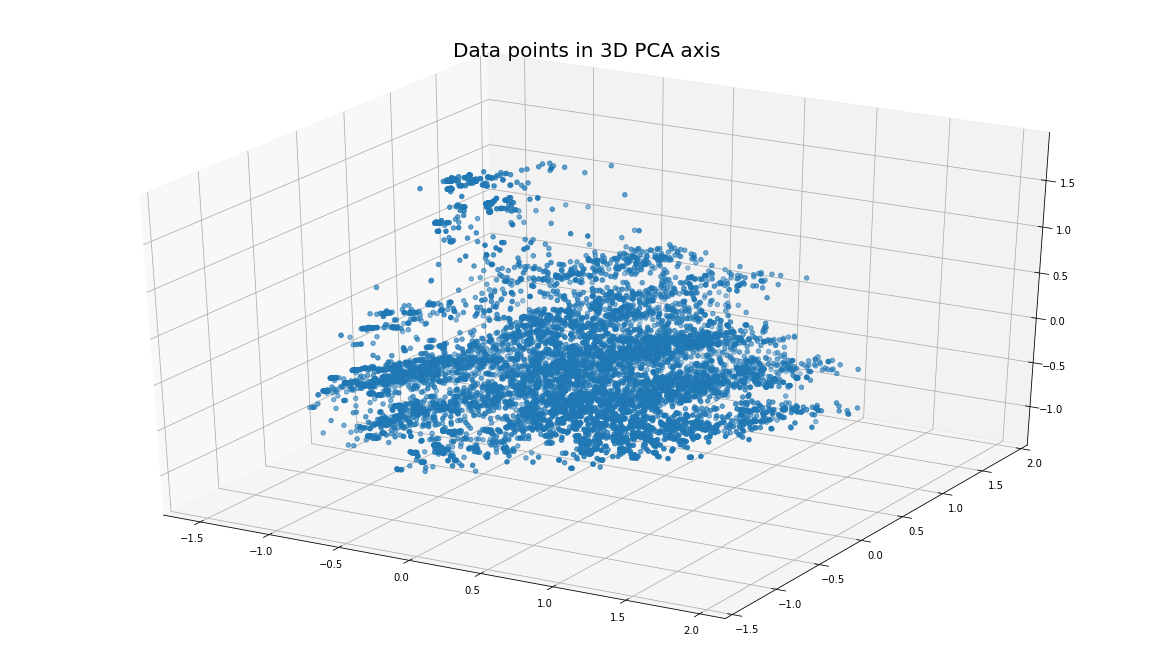

In [60]:
anime_tocluster = pd.DataFrame(anime_ps[[0,1,2]])
plt.rcParams['figure.figsize'] = (16, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(anime_tocluster[0], anime_tocluster[2], anime_tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

## Implementar modelo 1  GMM - GaussianMixture:

- No GaussianMixture iremos utilizar o silhouette_score e o BIC, para decidir a melhor quantidade de clusters no algoritimo.

In [61]:
anime_GMM_results = []
components = 20


for n in range(2, components):

    anime_GMM_clusterer = mixture.GaussianMixture(n_components=n).fit(anime_ps)
    anime_GMM_preds = anime_GMM_clusterer.predict(anime_ps)
    anime_GMM_centers = anime_GMM_clusterer.means_
    anime_GMM_sample_preds = anime_GMM_clusterer.predict(anime_pca_samples)
  
    anime_GMM_results.append(silhouette_score(anime_ps,anime_GMM_preds))
    print("Nº of clusters '{}', silhouette score is '{}' ".format(n,silhouette_score(anime_ps,anime_GMM_preds)))

Nº of clusters '2', silhouette score is '0.3010959566595053' 
Nº of clusters '3', silhouette score is '0.36662412138532885' 
Nº of clusters '4', silhouette score is '0.32002306402626474' 
Nº of clusters '5', silhouette score is '0.24816059436162932' 
Nº of clusters '6', silhouette score is '0.22132618016970518' 
Nº of clusters '7', silhouette score is '0.2420127759096275' 
Nº of clusters '8', silhouette score is '0.19093767283235188' 
Nº of clusters '9', silhouette score is '0.17729087218798897' 
Nº of clusters '10', silhouette score is '0.1746285450078162' 
Nº of clusters '11', silhouette score is '0.1876265777272065' 
Nº of clusters '12', silhouette score is '0.13640262782184107' 
Nº of clusters '13', silhouette score is '0.16774918408095382' 
Nº of clusters '14', silhouette score is '0.19159609453674004' 
Nº of clusters '15', silhouette score is '0.16805476824052484' 
Nº of clusters '16', silhouette score is '0.15096426219086506' 
Nº of clusters '17', silhouette score is '0.14057928

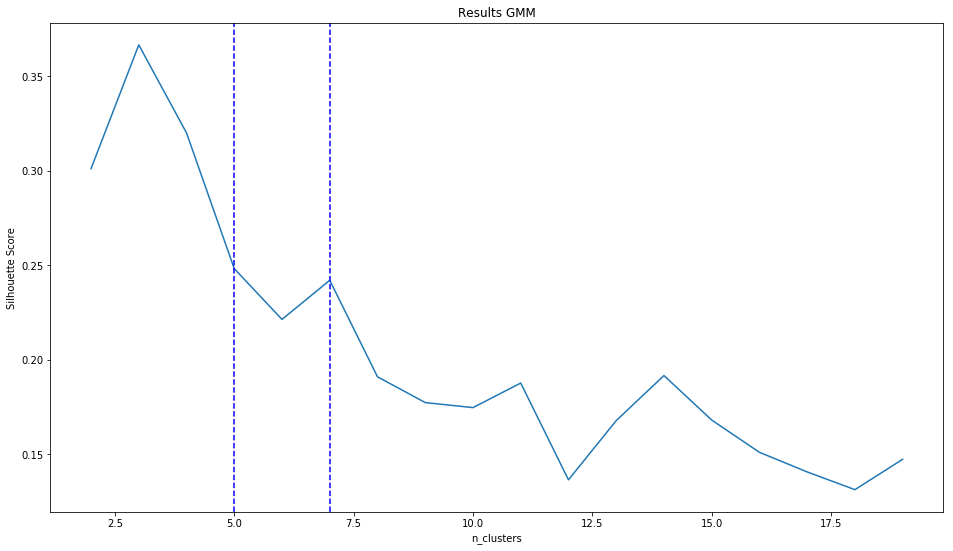

In [62]:
plt.plot(range(2,20), anime_GMM_results);
plt.title('Results GMM')
plt.xlabel('n_clusters');
plt.axvline(x=7, color='blue', linestyle='--')
plt.axvline(x=5, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

In [63]:
anime_GMM_results_BIC = []
components = 20

for n in range(2, components):

    anime_GMM_clusterer = mixture.GaussianMixture(n_components=n).fit(anime_ps)
    anime_GMM_preds = anime_GMM_clusterer.predict(anime_ps)
    anime_GMM_centers = anime_GMM_clusterer.means_
    
    anime_GMM_sample_preds = anime_GMM_clusterer.predict(anime_pca_samples)
  
    anime_GMM_results_BIC.append(anime_GMM_clusterer.bic(anime_ps))
    print("Nº of clusters '{}', BIC score is '{}' ".format(n,anime_GMM_clusterer.bic(anime_ps)))    

Nº of clusters '2', BIC score is '50230.730254247166' 
Nº of clusters '3', BIC score is '44861.1644924381' 
Nº of clusters '4', BIC score is '41563.13860216742' 
Nº of clusters '5', BIC score is '40383.72448349665' 
Nº of clusters '6', BIC score is '40043.522186331626' 
Nº of clusters '7', BIC score is '39158.64209233987' 
Nº of clusters '8', BIC score is '36573.68022102509' 
Nº of clusters '9', BIC score is '35652.10525936776' 
Nº of clusters '10', BIC score is '34310.317893278865' 
Nº of clusters '11', BIC score is '34340.07465442178' 
Nº of clusters '12', BIC score is '35589.79728783974' 
Nº of clusters '13', BIC score is '35139.62691490606' 
Nº of clusters '14', BIC score is '34317.38571437373' 
Nº of clusters '15', BIC score is '34256.62955282734' 
Nº of clusters '16', BIC score is '33676.07294870204' 
Nº of clusters '17', BIC score is '31794.681692630413' 
Nº of clusters '18', BIC score is '26230.280784362843' 
Nº of clusters '19', BIC score is '25771.96686404553' 


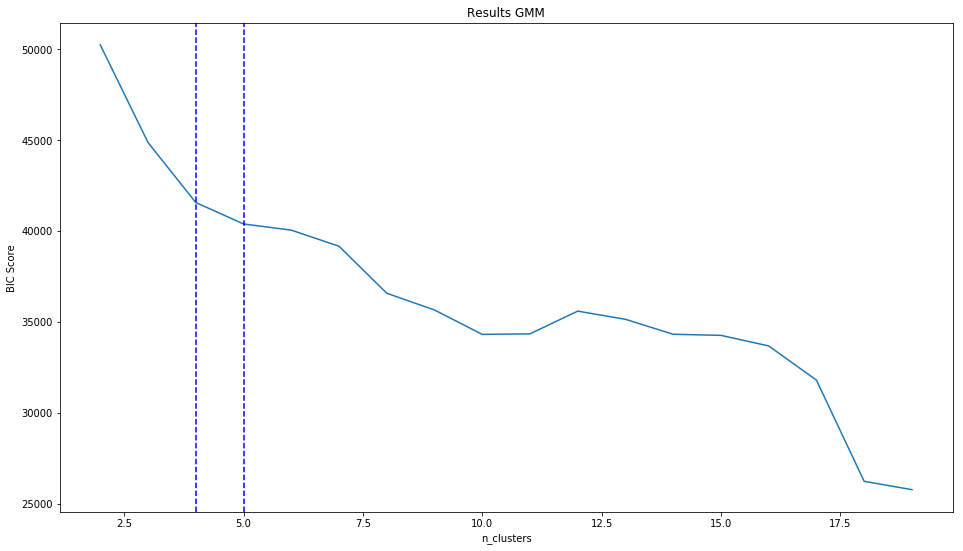

In [64]:
plt.plot(range(2,20), anime_GMM_results_BIC);
plt.title('Results GMM')
plt.xlabel('n_clusters');
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('BIC Score');
plt.show()

###  Resultado


#### BIC : K =4 ou 5


#### Silhouette Score : K = 5 ou 7

#### K =5 Escolhido, por aparecer como ótimo nas 2 Métricas


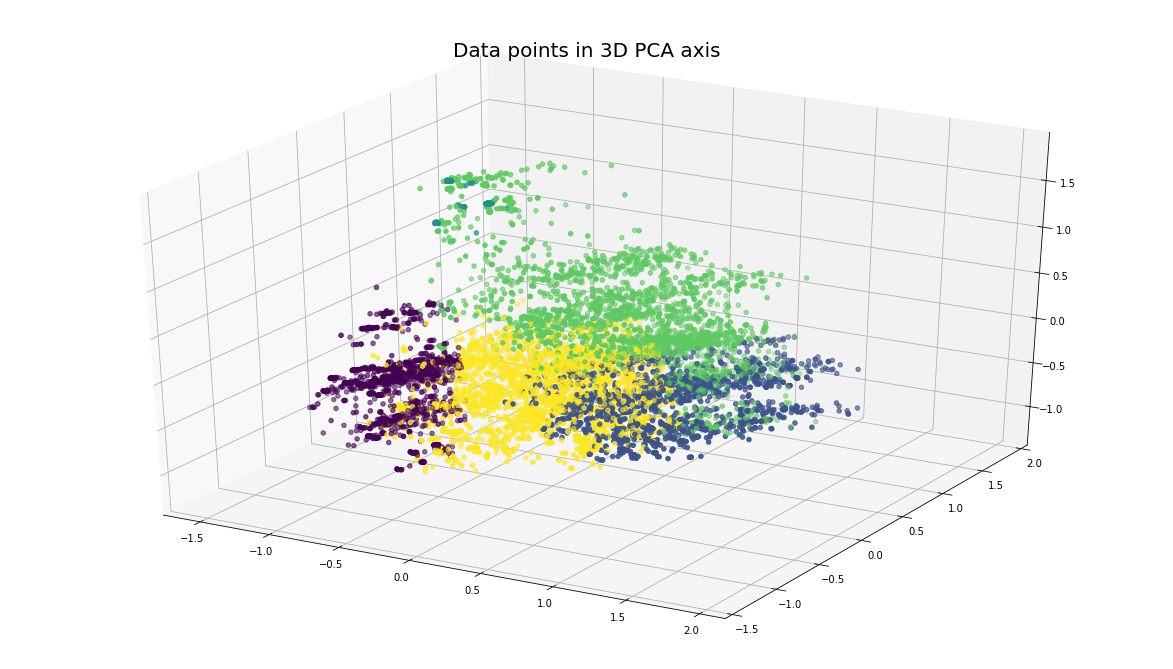

In [65]:
anime_GMM_clusterer = mixture.GaussianMixture(n_components=5).fit(anime_ps)
anime_GMM_preds = anime_GMM_clusterer.predict(anime_ps)
anime_GMM_centers = anime_GMM_clusterer.means_
anime_GMM_sample_preds = anime_GMM_clusterer.predict(anime_pca_samples)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(anime_tocluster[0], anime_tocluster[2], anime_tocluster[1], c = anime_GMM_sample_preds)

plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

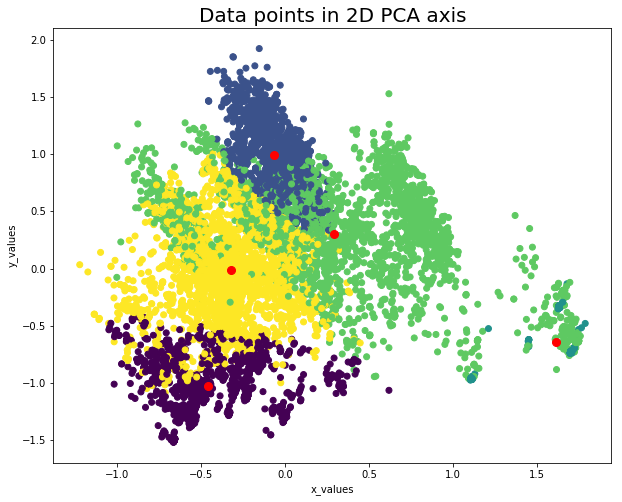

In [66]:
fig = plt.figure(figsize=(10,8))
plt.scatter(anime_tocluster[1],anime_tocluster[0],c = anime_GMM_sample_preds)
for ci,c in enumerate(anime_GMM_centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

## Implementar modelo 2 - KMeans:

- No KMeans iremos utilizar o silhouette_score e o elbow method, para decidir a melhor quantidade de clusters no algoritimo.

In [67]:
anime_kmean_results = []

for i in range(2,20):
    anime_kmeans = KMeans(n_clusters=i)
    anime_kmeans.fit(anime_ps)    
    anime_kmean_results.append(silhouette_score(anime_ps, anime_kmeans.labels_))
    print("Nº of clusters '{}', silhouette score is '{}' ".format(i,silhouette_score(anime_ps, anime_kmeans.labels_)))

Nº of clusters '2', silhouette score is '0.3202341337596337' 
Nº of clusters '3', silhouette score is '0.39053042428282464' 
Nº of clusters '4', silhouette score is '0.4148807765452877' 
Nº of clusters '5', silhouette score is '0.3597511190318592' 
Nº of clusters '6', silhouette score is '0.35244749223474714' 
Nº of clusters '7', silhouette score is '0.35623293154155555' 
Nº of clusters '8', silhouette score is '0.3491141557052561' 
Nº of clusters '9', silhouette score is '0.34653867661104204' 
Nº of clusters '10', silhouette score is '0.3382946830204464' 
Nº of clusters '11', silhouette score is '0.32415336023821717' 
Nº of clusters '12', silhouette score is '0.3359996223398449' 
Nº of clusters '13', silhouette score is '0.32967856475058155' 
Nº of clusters '14', silhouette score is '0.32662031041630407' 
Nº of clusters '15', silhouette score is '0.3274163034579781' 
Nº of clusters '16', silhouette score is '0.3281445029728768' 
Nº of clusters '17', silhouette score is '0.321160229026

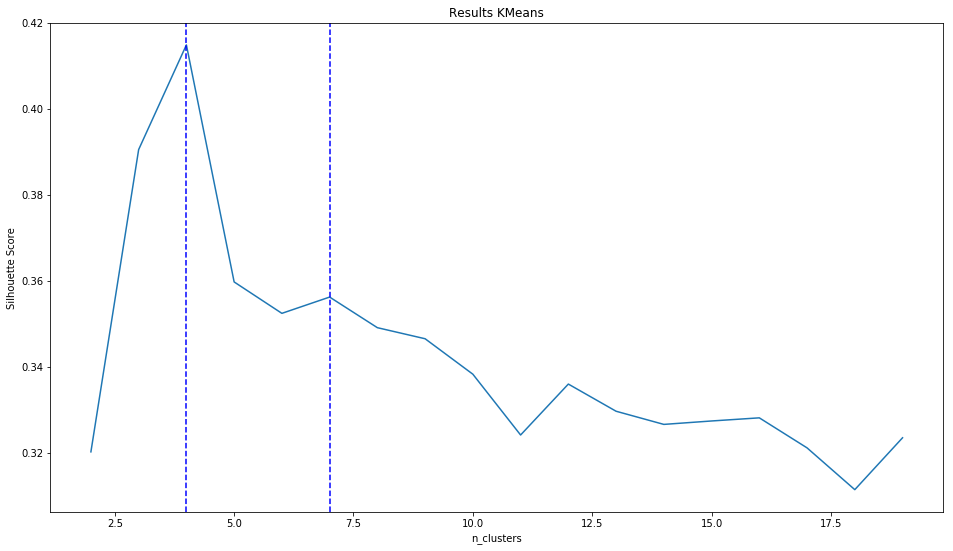

In [68]:
plt.plot(range(2,20), anime_kmean_results);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.axvline(x=7, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

In [69]:
anime_kmean_results_elbow = []

for i in range(2,20):
    anime_kmeans = KMeans(n_clusters=i)
    anime_kmeans.fit(anime_ps)    
    anime_kmean_results_elbow.append(anime_kmeans.inertia_)
    print("Nº of clusters '{}', Elbow Method  is '{}' ".format(i,anime_kmeans.inertia_))

Nº of clusters '2', Elbow Method  is '8763.705286829232' 
Nº of clusters '3', Elbow Method  is '5836.709212729106' 
Nº of clusters '4', Elbow Method  is '3906.4222614596033' 
Nº of clusters '5', Elbow Method  is '3367.38523143951' 
Nº of clusters '6', Elbow Method  is '2930.5248886195677' 
Nº of clusters '7', Elbow Method  is '2551.689411120773' 
Nº of clusters '8', Elbow Method  is '2337.0692066903707' 
Nº of clusters '9', Elbow Method  is '2144.728899636839' 
Nº of clusters '10', Elbow Method  is '1993.8864226228084' 
Nº of clusters '11', Elbow Method  is '1877.9923837479002' 
Nº of clusters '12', Elbow Method  is '1761.072926981993' 
Nº of clusters '13', Elbow Method  is '1655.9245670285472' 
Nº of clusters '14', Elbow Method  is '1580.1037939361086' 
Nº of clusters '15', Elbow Method  is '1496.104387472167' 
Nº of clusters '16', Elbow Method  is '1426.3626232211502' 
Nº of clusters '17', Elbow Method  is '1361.1302036399948' 
Nº of clusters '18', Elbow Method  is '1299.947063491550

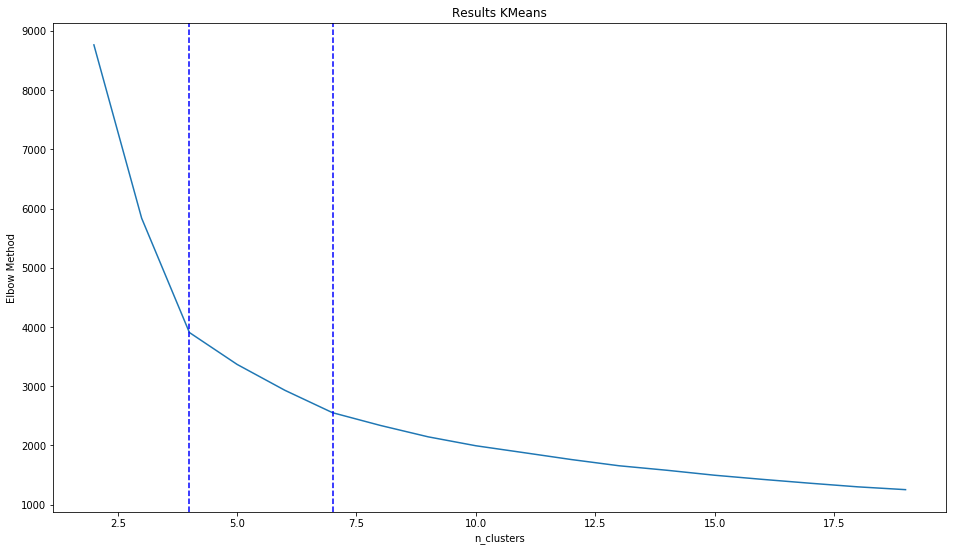

In [70]:
plt.plot(range(2,20), anime_kmean_results_elbow);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.axvline(x=7, color='blue', linestyle='--')
plt.ylabel('Elbow Method');
plt.show()

###  Resultado


#### Elbow Method : K = 4 ou 7


#### Silhouette Score : K = 4 ou 7

####  K=7 apresent uma possibilidade maior para adequadar a quantidade de gêneros e aparece como ótimo nas 2 métricas, Logo K escolhido é K=7.

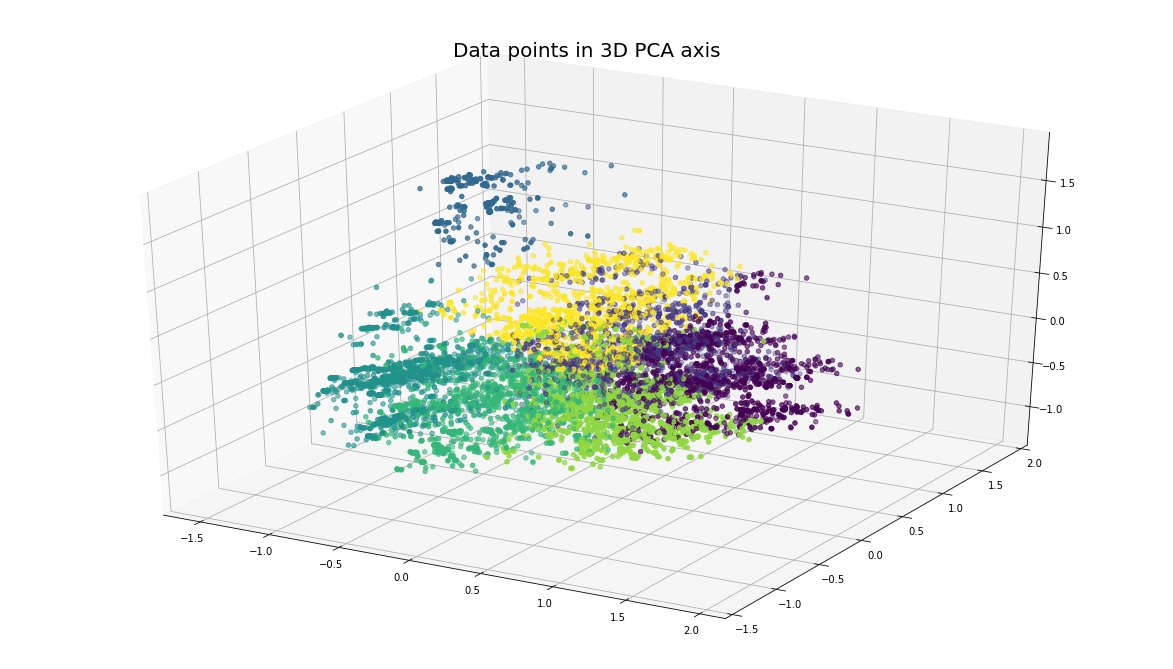

In [71]:
anime_kmean_clusterer = KMeans(n_clusters=7,random_state=30).fit(anime_tocluster)
anime_kmean_centers = anime_kmean_clusterer.cluster_centers_
anime_kmean_sample_preds = anime_kmean_clusterer.predict(anime_tocluster)


plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(anime_tocluster[0], anime_tocluster[2], anime_tocluster[1], c = anime_kmean_sample_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

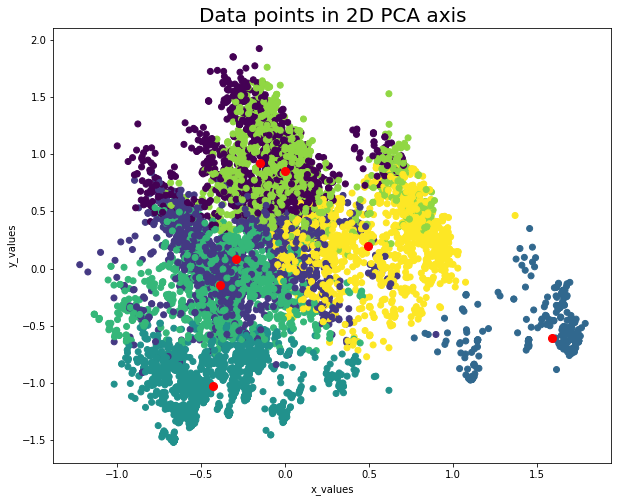

In [72]:
fig = plt.figure(figsize=(10,8))
plt.scatter(anime_tocluster[1],anime_tocluster[0],c = anime_kmean_sample_preds)
for ci,c in enumerate(anime_kmean_centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

## Recolher informações:


### Escolher melhor modelo

    - Modelo escolhido o Kmeans com K =7, pois a pontução nas métricas foi superior, isso se deve pelo fato do Kmeans identificar melhor grupos facilmente visíveis de data points, como é este o caso. 
    


### Retirar Informações de cada Kluster

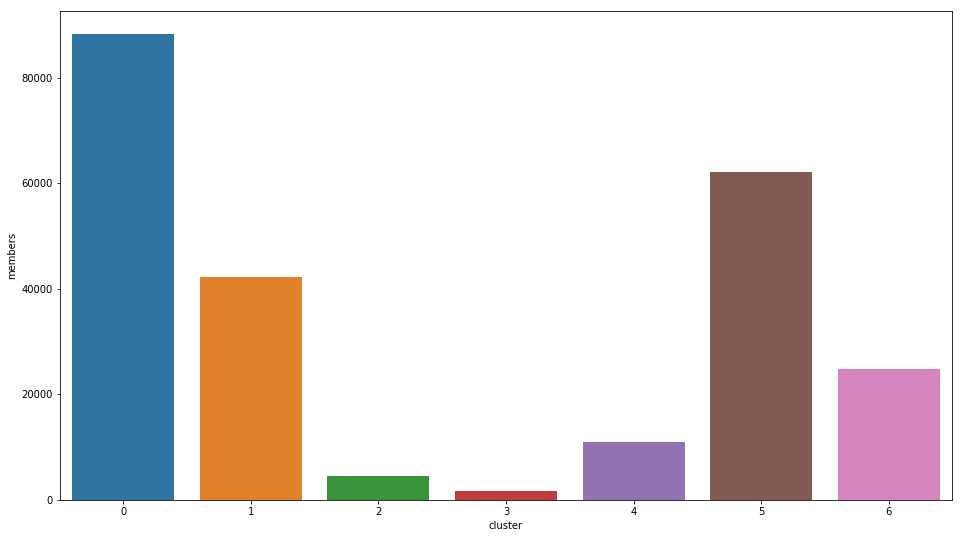

In [73]:
anime_features['cluster'] = anime_kmean_sample_preds
anime['cluster'] = anime_kmean_sample_preds

cluster_members_anime_series = anime_features.groupby('cluster')['members'].mean().reset_index()
cluster_members_anime = pd.DataFrame(data = cluster_members_anime_series)
cluster_members_anime = cluster_members_anime.sort_values("members")
sns.barplot(y=cluster_members_anime['members'],x=cluster_members_anime['cluster'])

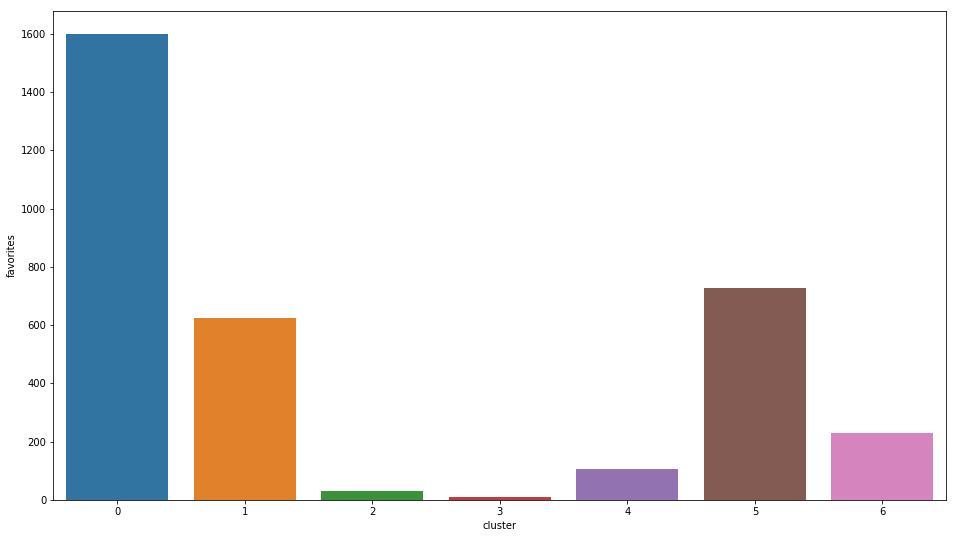

In [74]:
cluster_favorites_anime_series = anime_features.groupby('cluster')['favorites'].mean().reset_index()
cluster_favorites_anime = pd.DataFrame(data = cluster_favorites_anime_series)
cluster_favorites_anime = cluster_favorites_anime.sort_values("favorites")
sns.barplot(y=cluster_favorites_anime['favorites'],x=cluster_favorites_anime['cluster'])

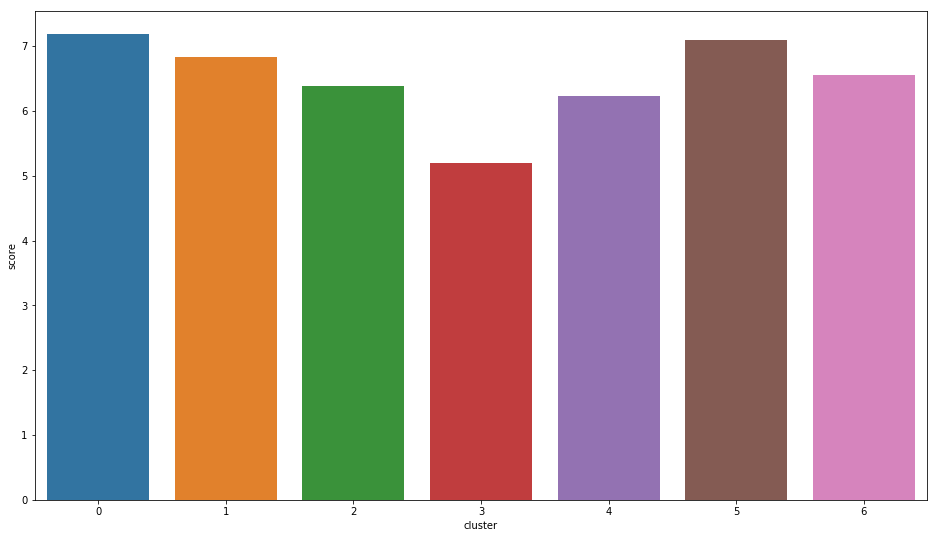

In [75]:
cluster_score_anime_series = anime_features.groupby('cluster')['score'].mean().reset_index()
cluster_score_anime = pd.DataFrame(data = cluster_score_anime_series)
cluster_score_anime = cluster_score_anime.sort_values("score")
sns.barplot(y=cluster_score_anime['score'],x=cluster_score_anime['cluster'])

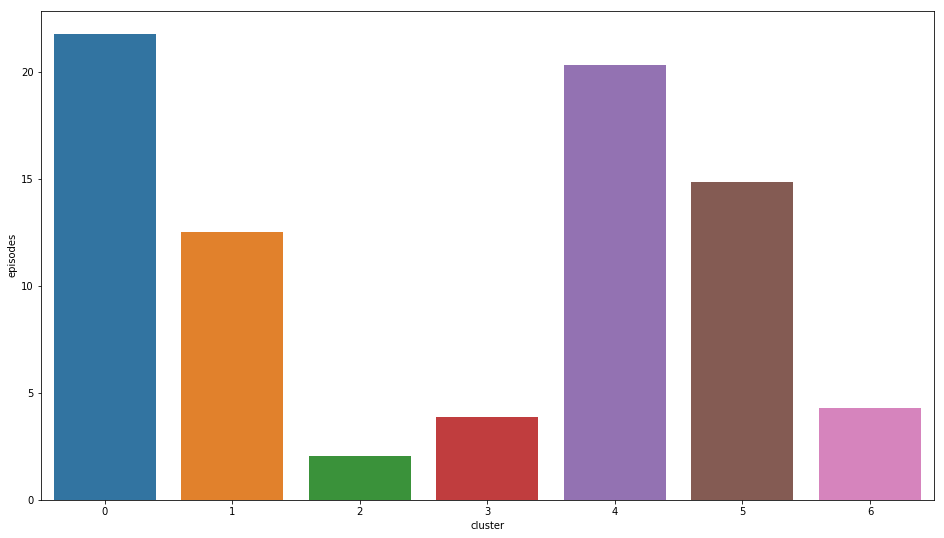

In [76]:
cluster_episodes_anime_series = anime_features.groupby('cluster')['episodes'].mean().reset_index()
cluster_episodes_anime = pd.DataFrame(data = cluster_episodes_anime_series)
cluster_episodes_anime = cluster_episodes_anime.sort_values("episodes")
sns.barplot(y=cluster_episodes_anime['episodes'],x=cluster_episodes_anime['cluster'])

In [77]:
c0 = anime[anime['cluster'] == 0].groupby('rating')['rating'].count()
c1 = anime[anime['cluster'] == 1].groupby('rating')['rating'].count()
c2 = anime[anime['cluster'] == 2].groupby('rating')['rating'].count()
c3 = anime[anime['cluster'] == 3].groupby('rating')['rating'].count()
c4 = anime[anime['cluster'] == 4].groupby('rating')['rating'].count()
c5 = anime[anime['cluster'] == 5].groupby('rating')['rating'].count()
c6 = anime[anime['cluster'] == 6].groupby('rating')['rating'].count()


anime_cluster = pd.DataFrame(
    {'Cluster 1': c0,
     'Cluster 2': c1,
     'Cluster 3': c2,
     'Cluster 4': c3,
     'Cluster 5': c4,
     'Cluster 6': c5,
     'Cluster 7': c6    
    })

cluster_genre_series = anime.groupby('cluster').sum()

In [78]:
anime_cluster

Cluster 1  Cluster 2  Cluster 3  Cluster 4  \
G - All Ages                          3.0         98        NaN       1892   
PG - Children                        35.0        181        NaN         75   
PG-13 - Teens 13 or older           953.0        737        NaN         13   
R - 17+ (violence & profanity)      145.0        323        2.0         10   
R+ - Mild Nudity                     59.0        127        2.0         44   
Rx - Hentai                           NaN          1      927.0          3   

                                Cluster 5  Cluster 6  Cluster 7  
G - All Ages                        718.0       28.0         36  
PG - Children                       255.0       72.0         53  
PG-13 - Teens 13 or older           359.0     1338.0        494  
R - 17+ (violence & profanity)       21.0       59.0        261  
R+ - Mild Nudity                     35.0      168.0        260  
Rx - Hentai                           NaN        NaN          7

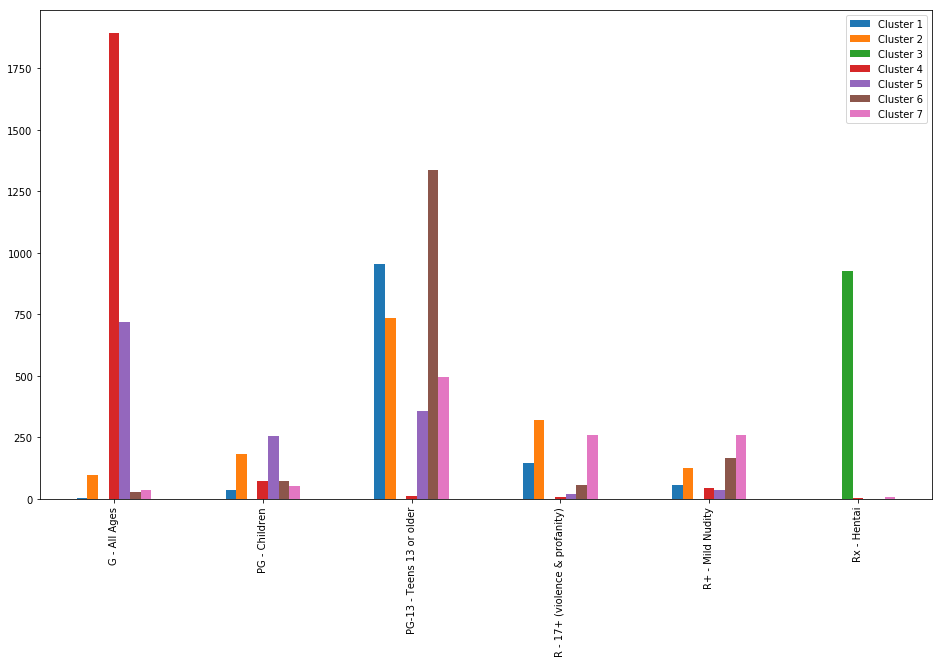

In [79]:
anime_cluster.plot(kind='bar')

In [80]:
c0_source = anime[anime['cluster'] == 0].groupby('source')['source'].count()
c1_source = anime[anime['cluster'] == 1].groupby('source')['source'].count()
c2_source = anime[anime['cluster'] == 2].groupby('source')['source'].count()
c3_source = anime[anime['cluster'] == 3].groupby('source')['source'].count()
c4_source = anime[anime['cluster'] == 4].groupby('source')['source'].count()
c5_source = anime[anime['cluster'] == 5].groupby('source')['source'].count()
c6_source = anime[anime['cluster'] == 6].groupby('source')['source'].count()


anime_cluster_source = pd.DataFrame(
    {'Cluster 1': c0_source,
     'Cluster 2': c1_source,
     'Cluster 3': c2_source,
     'Cluster 4': c3_source,
     'Cluster 5': c4_source,
     'Cluster 6': c5_source,
     'Cluster 7': c6_source   
    })


In [81]:
anime_cluster_source

Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5  \
4-koma manga         1.0        NaN        NaN        4.0         57   
Book                 3.0       11.0        1.0       43.0         26   
Card game            8.0       11.0        NaN        6.0         11   
Digital manga        NaN        NaN        1.0        NaN          3   
Game                90.0      174.0        NaN       65.0        127   
Light novel        135.0       81.0       12.0        2.0         17   
Manga              733.0       69.0      239.0       12.0        292   
Music                NaN        3.0        NaN      247.0         54   
Novel               39.0       82.0        3.0       52.0         64   
Original           118.0      957.0      105.0     1399.0        541   
Other               17.0       43.0        2.0      155.0        108   
Picture book         NaN        3.0        NaN       42.0         45   
Radio                NaN        1.0        NaN        2.0          5   
Visual novel        29.0       23.0      568.0        4.0          6   
Web manga           22.0        9.0        NaN        4.0         32   

               Cluster 6  Cluster 7  
4-koma manga       148.0        4.0  
Book                 2.0        4.0  
Card game           13.0        5.0  
Digital manga        4.0        NaN  
Game                30.0       77.0  
Light novel        179.0      103.0  
Manga             1099.0      534.0  
Music                5.0        2.0  
Novel               16.0       78.0  
Original            12.0       88.0  
Other               15.0       46.0  
Picture book         NaN        2.0  
Radio                1.0        NaN  
Visual novel        90.0      154.0  
Web manga           51.0       14.0

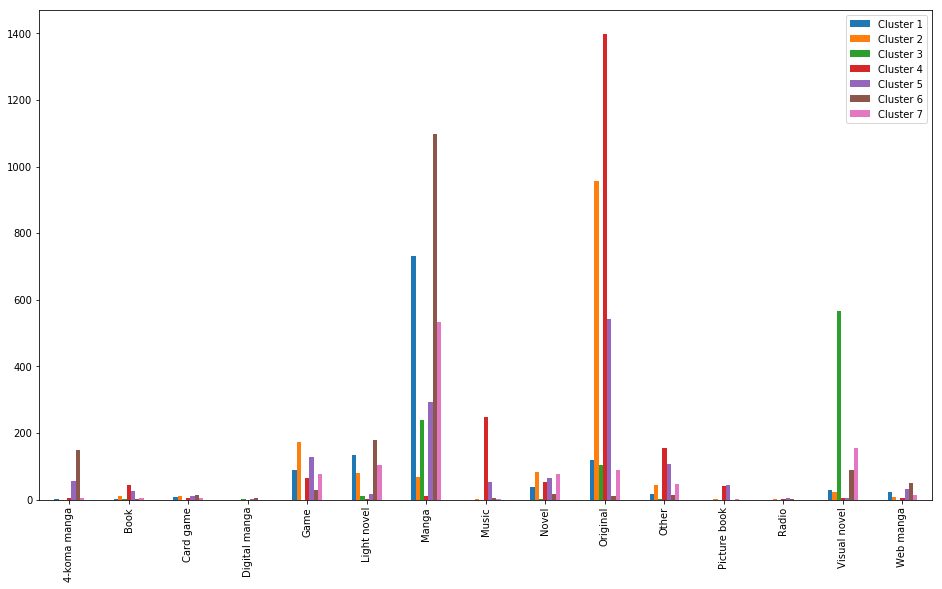

In [82]:
anime_cluster_source.plot(kind='bar')

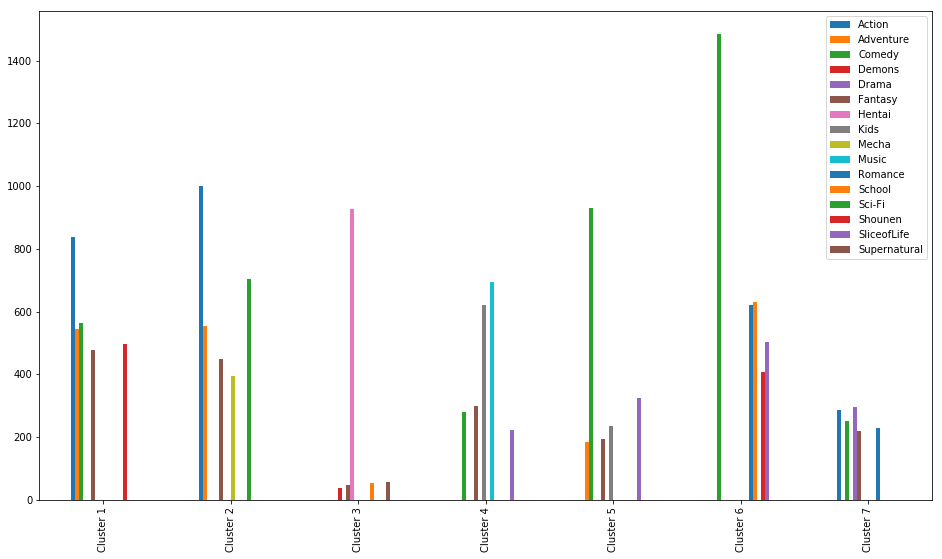

In [83]:
genre = anime["genre"].str.get_dummies(sep=",")
genre['cluster'] = anime_kmean_sample_preds


cluster_genre_series = genre.groupby('cluster').sum()

cluster_genre_series = pd.DataFrame(cluster_genre_series)
cluster_genre_series = cluster_genre_series.transpose()

genre_c0 = cluster_genre_series.nlargest(5, 0)[0]
genre_c1 = cluster_genre_series.nlargest(5, 1)[1]
genre_c2 = cluster_genre_series.nlargest(5, 2)[2]
genre_c3 = cluster_genre_series.nlargest(5, 3)[3]
genre_c4 = cluster_genre_series.nlargest(5, 4)[4]
genre_c5 = cluster_genre_series.nlargest(5, 5)[5]
genre_c6 = cluster_genre_series.nlargest(5, 6)[6]


cluster_genre_series = pd.DataFrame({
     'Cluster 1': genre_c0,
     'Cluster 2': genre_c1,
     'Cluster 3': genre_c2,
     'Cluster 4': genre_c3,
     'Cluster 5': genre_c4,
     'Cluster 6': genre_c5,
     'Cluster 7': genre_c6   
    })

cluster_genre_series_plot = cluster_genre_series.transpose()
cluster_genre_series_plot.plot(kind='bar')

# Implementação do Modelo para Filtro Colaborativo, Users

- O modelo relaciona pessoas com interesses similares e recomenda baseado nesse inter-relacionamento

- ### Preparação da Tabela para o Modelo

- Não podemos usar o np.log pois criaria valores NaN, impossibilitando o PCA. Então estamos usando o MinMaxScaler.
- PCA = 3 para podermos visualizar os resultados
- Criação das colunas "dummies" para podermos utilizar as colunas classificatórias no modelo.

In [84]:
anime_list = anime_list[anime_list['anime_id'].isin(anime['anime_id'])]

In [85]:
anime_list = anime_list[anime_list['username'].isin(users['username'])]


In [86]:
anime_list = anime_list.drop(['username'], axis = 1)

In [87]:
merge_data = pd.merge(anime_list,users,on=['user_id','user_id'])

In [88]:
merge_data.head()

anime_id  my_score          title  user_id  username  gender  \
0        21         9      One Piece  2255153  karthiga  Female   
1        59         7        Chobits  2255153  karthiga  Female   
2        74         7   Gakuen Alice  2255153  karthiga  Female   
3       120         7  Fruits Basket  2255153  karthiga  Female   
4       178         7   Ultra Maniac  2255153  karthiga  Female   

   stats_mean_score  age  
0              7.43   28  
1              7.43   28  
2              7.43   28  
3              7.43   28  
4              7.43   28

In [89]:
users_features = pd.crosstab(merge_data['user_id'], merge_data['title'], values=merge_data.my_score, aggfunc='sum' )

In [90]:
users_features.head()

title    "Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi  "Bungaku Shoujo" Memoire  \
user_id                                                                        
3                                              NaN                       NaN   
20                                             NaN                       NaN   
37                                             NaN                       NaN   
66                                             NaN                       NaN   
81                                             NaN                       NaN   

title    "Bungaku Shoujo" Movie  "Eiji"  "Eiyuu" Kaitai  "Parade" de Satie  \
user_id                                                                      
3                           NaN     NaN             NaN                NaN   
20                          NaN     NaN             NaN                NaN   
37                          NaN     NaN             NaN                NaN   
66                          NaN     NaN             NaN                NaN   
81                          NaN     NaN             NaN                NaN   

title    (a long day of) Mr. Calpaccio  .hack//G.U. Returner  \
user_id                                                        
3                                  NaN                   NaN   
20                                 NaN                   NaN   
37                                 NaN                   NaN   
66                                 NaN                   NaN   
81                                 NaN                   NaN   

title    .hack//G.U. Trilogy  .hack//G.U. Trilogy: Parody Mode ...  \
user_id                                                        ...   
3                        NaN                               NaN ...   
20                       NaN                               NaN ...   
37                       NaN                               NaN ...   
66                       NaN                               NaN ...   
81                       NaN                               NaN ...   

title    iDOLM@STER Xenoglossia  makemagic  s.CRY.ed  vivi  xxxHOLiC  \
user_id                                                                
3                           NaN        NaN       NaN   NaN       NaN   
20                          NaN        NaN       NaN   NaN       NaN   
37                          NaN        NaN       NaN   NaN       NaN   
66                          NaN        NaN       NaN   NaN       NaN   
81                          NaN        NaN       NaN   NaN       8.0   

title    xxxHOLiC Kei  xxxHOLiC Movie: Manatsu no Yoru no Yume  \
user_id                                                          
3                 NaN                                      NaN   
20                NaN                                      NaN   
37                NaN                                      NaN   
66                NaN                                      NaN   
81                8.0                                      7.0   

title    xxxHOLiC Shunmuki  ēlDLIVE   ◯  
user_id                                  
3                      NaN      NaN NaN  
20                     NaN      NaN NaN  
37                     NaN      NaN NaN  
66                     NaN      NaN NaN  
81                     7.0      NaN NaN  

[5 rows x 8055 columns]

In [91]:
where_are_NaNs = np.isnan(users_features)
users_features[where_are_NaNs] = 0
min_max_scaler = MinMaxScaler()
users_features_scaled = min_max_scaler.fit_transform(users_features)

In [92]:
users_pca = PCA(n_components=3)
users_pca.fit(users_features_scaled)
users_pca_samples = users_pca.transform(users_features_scaled)
users_ps = pd.DataFrame(users_pca_samples)
users_ps.head(15)

0         1         2
0  -0.876573  4.037622 -1.103379
1  -0.637512  1.767809 -2.097310
2  -1.272241  0.181287  0.496492
3  -1.617643  2.692325  0.408799
4  -0.162892  0.464988 -0.461021
5  -0.179532  1.122711  0.054089
6  -0.442513  0.861395 -1.253223
7  -1.896665 -1.136953  0.130361
8  -1.629275  3.431419 -0.241941
9  -1.377686  3.491964 -1.302006
10 -1.455642  2.615735  0.218506
11  0.047657  2.040042 -1.412575
12 -1.727361  1.792952 -0.473612
13 -2.038713 -1.154903  0.367693
14 -1.769492  0.370756  0.671948

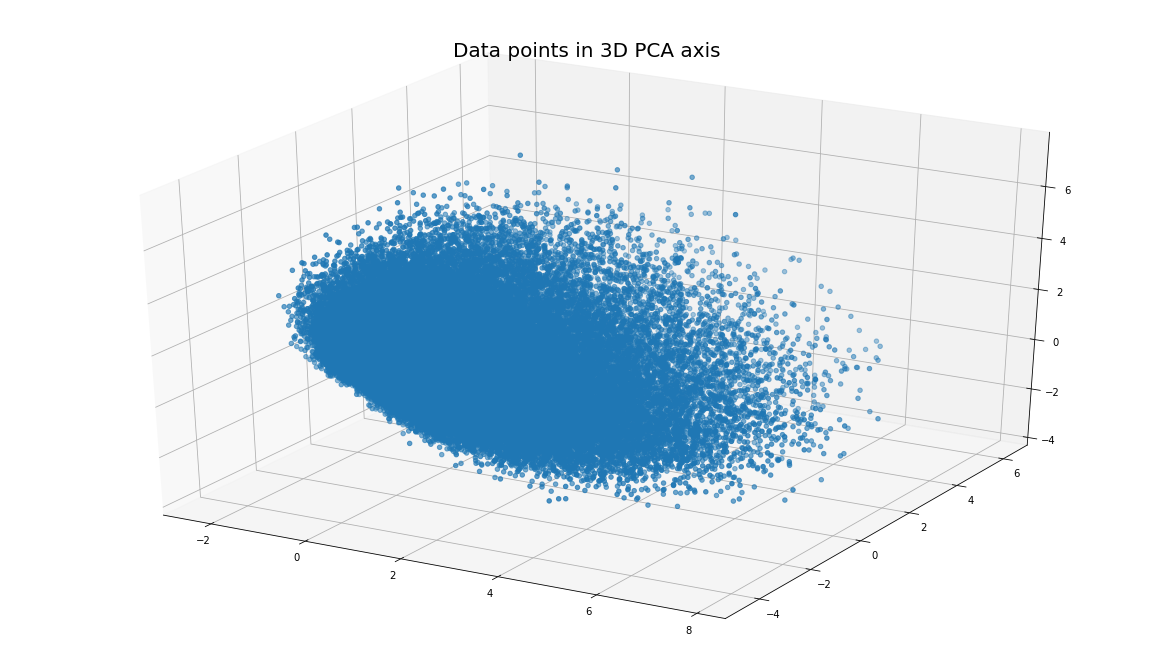

In [93]:
users_tocluster = pd.DataFrame(users_ps[[0,1,2]])
plt.rcParams['figure.figsize'] = (16, 9)


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(users_tocluster[0], users_tocluster[2], users_tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

## Implementar modelo 1  GMM - GaussianMixture:

- No GaussianMixture iremos utilizar o silhouette_score e o BIC, para decidir a melhor quantidade de clusters no algoritimo.

In [94]:
users_GMM_results = []
components = 20


for n in range(2, components):

    users_GMM_clusterer = mixture.GaussianMixture(n_components=n).fit(users_ps)
    users_GMM_preds = users_GMM_clusterer.predict(users_ps)
    users_GMM_centers = users_GMM_clusterer.means_
    users_GMM_sample_preds = users_GMM_clusterer.predict(users_pca_samples)
     
    users_GMM_results.append(silhouette_score(users_ps,users_GMM_preds))
    print("Nº of clusters '{}', silhouette score is '{}' ".format(n,silhouette_score(users_ps,users_GMM_preds)))

Nº of clusters '2', silhouette score is '0.2413533790672654' 
Nº of clusters '3', silhouette score is '0.11390020712758517' 
Nº of clusters '4', silhouette score is '0.12192319735456' 
Nº of clusters '5', silhouette score is '0.15455143424630394' 
Nº of clusters '6', silhouette score is '0.07178200654272247' 
Nº of clusters '7', silhouette score is '0.09512286474211674' 
Nº of clusters '8', silhouette score is '0.10013095765043724' 
Nº of clusters '9', silhouette score is '0.12293986414883203' 
Nº of clusters '10', silhouette score is '0.11277506027059128' 
Nº of clusters '11', silhouette score is '0.1279219850704967' 
Nº of clusters '12', silhouette score is '0.13886548237122667' 
Nº of clusters '13', silhouette score is '0.14011889740971753' 
Nº of clusters '14', silhouette score is '0.1351023531464797' 
Nº of clusters '15', silhouette score is '0.13036449387268556' 
Nº of clusters '16', silhouette score is '0.13750782608569706' 
Nº of clusters '17', silhouette score is '0.1508655010

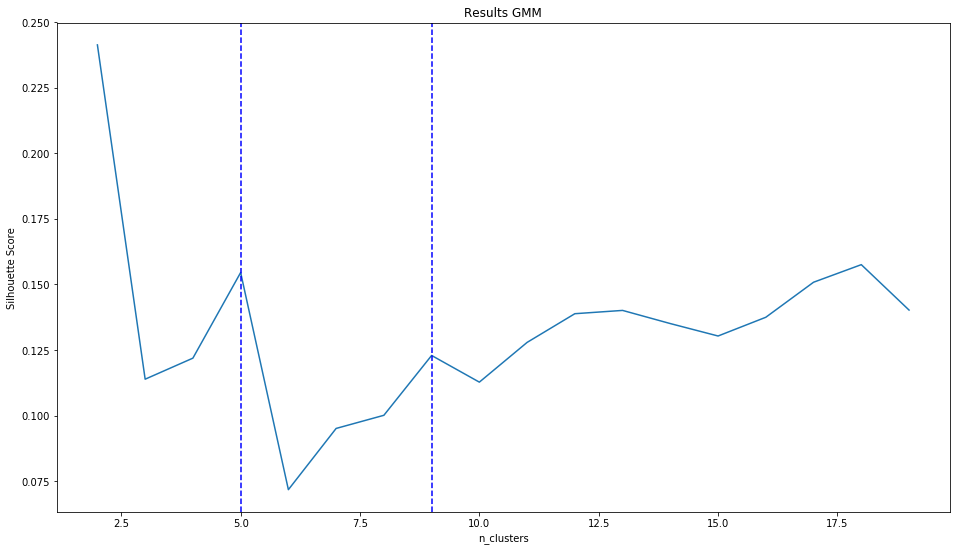

In [95]:
plt.plot(range(2,20), users_GMM_results);
plt.title('Results GMM')
plt.xlabel('n_clusters');
plt.ylabel('Silhouette Score');
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=9, color='blue', linestyle='--')
plt.show()

In [96]:
users_GMM_results_BIC = []
components = 20


for n in range(2, components):

    users_GMM_clusterer = mixture.GaussianMixture(n_components=n).fit(users_ps)
    users_GMM_preds = users_GMM_clusterer.predict(users_ps)
    users_GMM_centers = users_GMM_clusterer.means_
    users_GMM_sample_preds = users_GMM_clusterer.predict(users_pca_samples)
     
    users_GMM_results_BIC.append(users_GMM_clusterer.bic(users_ps))
    print("Nº of clusters '{}', silhouette score is '{}' ".format(n,users_GMM_clusterer.bic(users_ps)))

Nº of clusters '2', silhouette score is '707329.6104866738' 
Nº of clusters '3', silhouette score is '687554.3294122576' 
Nº of clusters '4', silhouette score is '679204.2565891062' 
Nº of clusters '5', silhouette score is '676020.663436145' 
Nº of clusters '6', silhouette score is '629844.8666425591' 
Nº of clusters '7', silhouette score is '629012.2207562563' 
Nº of clusters '8', silhouette score is '627272.3509670817' 
Nº of clusters '9', silhouette score is '625927.7782038054' 
Nº of clusters '10', silhouette score is '624197.2037574418' 
Nº of clusters '11', silhouette score is '624896.1745242347' 
Nº of clusters '12', silhouette score is '624094.4393918139' 
Nº of clusters '13', silhouette score is '623041.2409324507' 
Nº of clusters '14', silhouette score is '623157.1881044436' 
Nº of clusters '15', silhouette score is '622964.6364984174' 
Nº of clusters '16', silhouette score is '623054.4237339238' 
Nº of clusters '17', silhouette score is '621434.4698171559' 
Nº of clusters '1

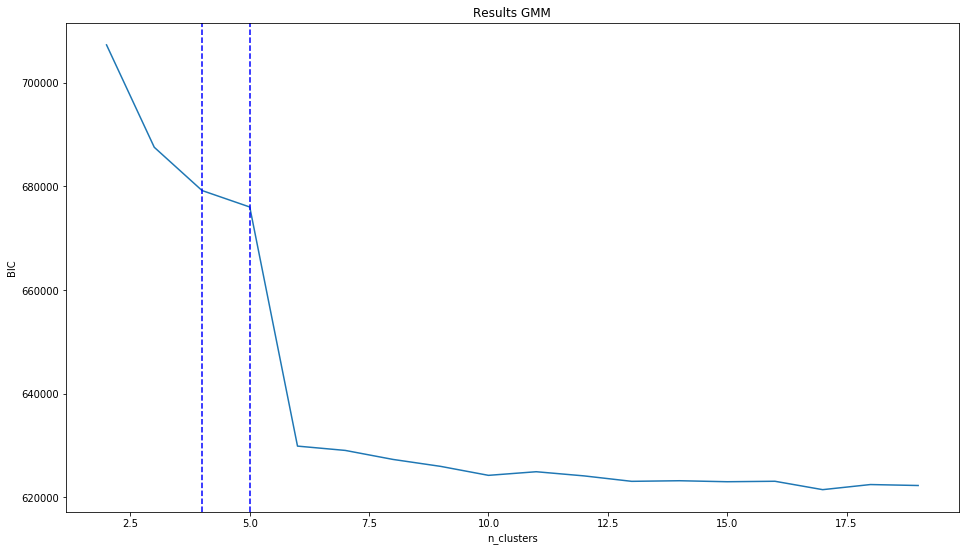

In [97]:
plt.plot(range(2,20), users_GMM_results_BIC);
plt.title('Results GMM')
plt.xlabel('n_clusters');
plt.ylabel('BIC');
plt.axvline(x=5, color='blue', linestyle='--')
plt.axvline(x=4, color='blue', linestyle='--')
plt.show()

###  Resultado


#### BIC : K =4 ou 5


#### Silhouette Score : K = 5 ou 10

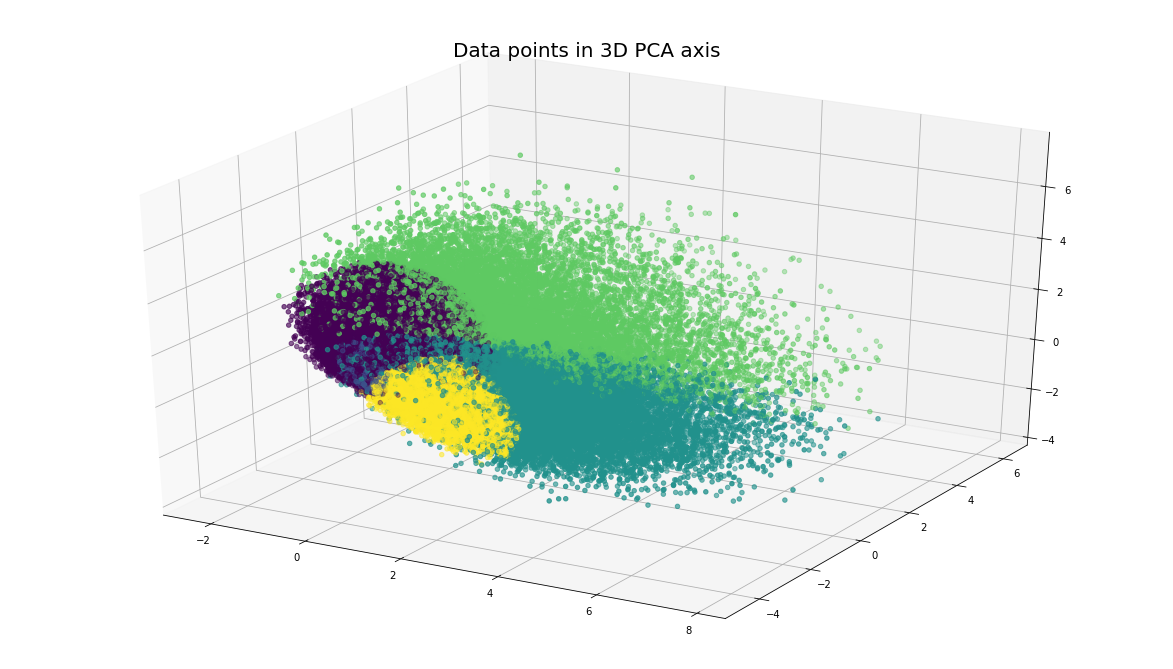

In [98]:
users_GMM_clusterer = mixture.GaussianMixture(n_components=5).fit(users_ps)
users_GMM_preds = users_GMM_clusterer.predict(users_ps)
users_GMM_centers = users_GMM_clusterer.means_
users_GMM_sample_preds = users_GMM_clusterer.predict(users_pca_samples)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(users_tocluster[0], users_tocluster[2], users_tocluster[1], c = users_GMM_sample_preds)

plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

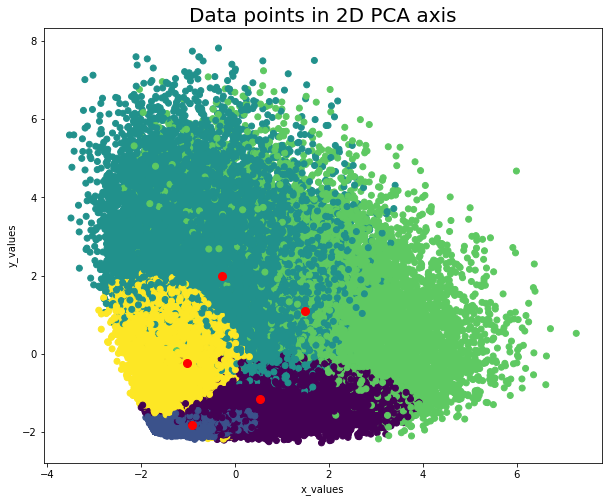

In [99]:
fig = plt.figure(figsize=(10,8))
plt.scatter(users_tocluster[1],users_tocluster[0],c = users_GMM_sample_preds)
for ci,c in enumerate(users_GMM_centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)
plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

## Implementar modelo 2  - Kmeans:

- No Kmeans iremos utilizar o silhouette_score e o metodo do cotovelo, para decidir a melhor quantidade de clusters no algoritimo.

In [100]:
users_kmeans_results = []

for i in range(2,20):
    users_kmeans = KMeans(n_clusters=i)
    users_kmeans.fit(users_ps)    
    users_kmeans_results.append(silhouette_score(users_ps, users_kmeans.labels_))
    print("Nº of clusters '{}', silhouette score is '{}' ".format(i,silhouette_score(users_ps, users_kmeans.labels_)))

Nº of clusters '2', silhouette score is '0.3852394965110858' 
Nº of clusters '3', silhouette score is '0.3611565110477599' 
Nº of clusters '4', silhouette score is '0.3592914345253146' 
Nº of clusters '5', silhouette score is '0.3325953764094886' 
Nº of clusters '6', silhouette score is '0.29152042713180165' 
Nº of clusters '7', silhouette score is '0.2924995842177583' 
Nº of clusters '8', silhouette score is '0.29196793413992966' 
Nº of clusters '9', silhouette score is '0.2902749943968839' 
Nº of clusters '10', silhouette score is '0.29445330113794865' 
Nº of clusters '11', silhouette score is '0.27243149847832304' 
Nº of clusters '12', silhouette score is '0.2670613981153607' 
Nº of clusters '13', silhouette score is '0.2732184035011564' 
Nº of clusters '14', silhouette score is '0.26822130818034556' 
Nº of clusters '15', silhouette score is '0.2696257101746623' 
Nº of clusters '16', silhouette score is '0.2659754408688743' 
Nº of clusters '17', silhouette score is '0.26482861962499

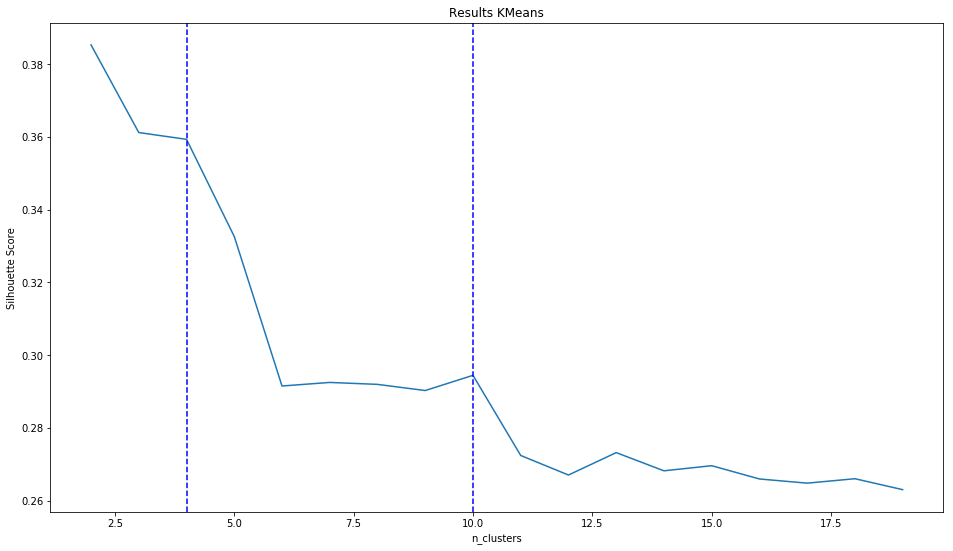

In [101]:
plt.plot(range(2,20), users_kmeans_results);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.axvline(x=10, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

In [102]:
users_kmean_results_elbow = []


for i in range(2,20):
    users_kmeans = KMeans(n_clusters=i)
    users_kmeans.fit(users_ps)    
    users_kmean_results_elbow.append(users_kmeans.inertia_)
    print("Nº of clusters '{}', Elbow Method is '{}' ".format(i,users_kmeans.inertia_))

Nº of clusters '2', Elbow Method is '315689.6178194149' 
Nº of clusters '3', Elbow Method is '229991.53012319264' 
Nº of clusters '4', Elbow Method is '193829.80694100863' 
Nº of clusters '5', Elbow Method is '169067.7287197994' 
Nº of clusters '6', Elbow Method is '150166.34422054174' 
Nº of clusters '7', Elbow Method is '134960.48373818936' 
Nº of clusters '8', Elbow Method is '124087.80658019538' 
Nº of clusters '9', Elbow Method is '114698.1861117484' 
Nº of clusters '10', Elbow Method is '107721.68448893951' 
Nº of clusters '11', Elbow Method is '101233.08182219132' 
Nº of clusters '12', Elbow Method is '95929.8005600414' 
Nº of clusters '13', Elbow Method is '91056.56901877157' 
Nº of clusters '14', Elbow Method is '86596.83556550123' 
Nº of clusters '15', Elbow Method is '82815.58645167243' 
Nº of clusters '16', Elbow Method is '79253.09745177464' 
Nº of clusters '17', Elbow Method is '76281.67946740068' 
Nº of clusters '18', Elbow Method is '73558.92705400503' 
Nº of clusters '

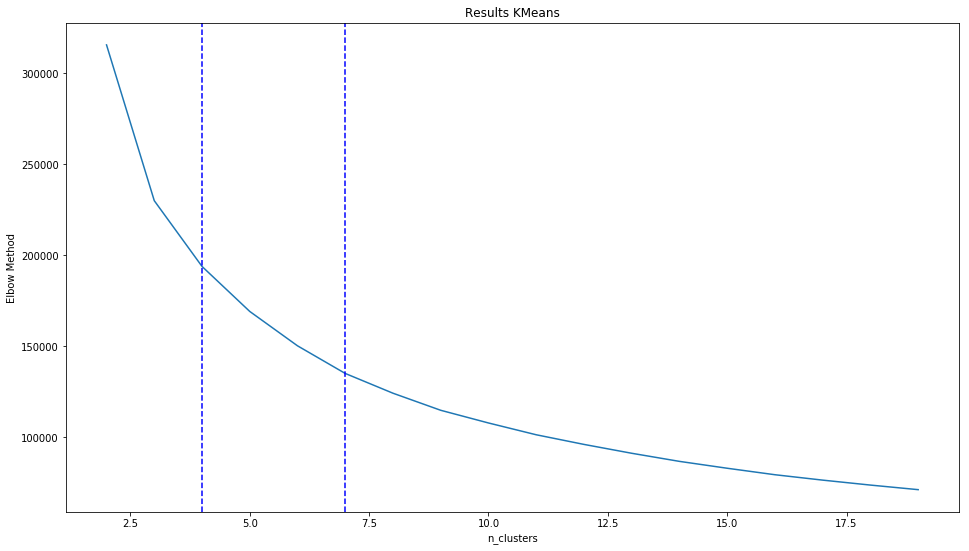

In [103]:
plt.plot(range(2,20), users_kmean_results_elbow);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.axvline(x=7, color='blue', linestyle='--')
plt.ylabel('Elbow Method');
plt.show()

###  Resultado


#### Elbow Method : K = 4 ou 7


#### Silhouette Score : K = 4 ou 10

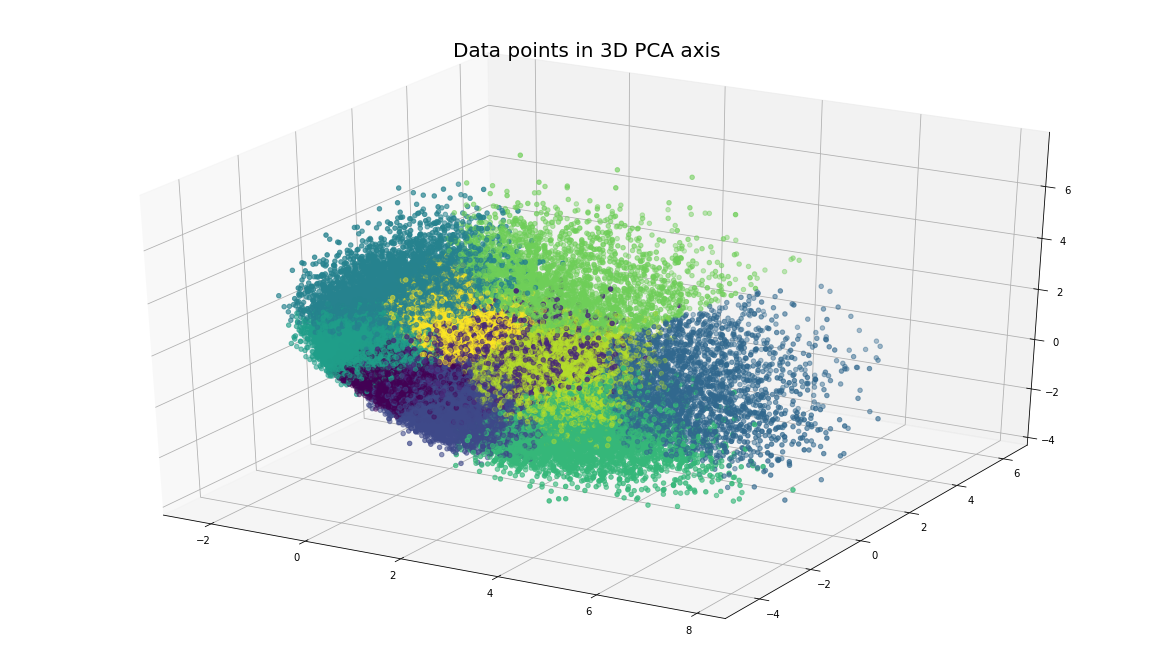

In [104]:
users_kmeans_clusterer = KMeans(n_clusters=10,random_state=30).fit(users_tocluster)
users_kmeans_centers = users_kmeans_clusterer.cluster_centers_
users_kmeans_sample_preds = users_kmeans_clusterer.predict(users_tocluster)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(users_tocluster[0], users_tocluster[2], users_tocluster[1], c = users_kmeans_sample_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

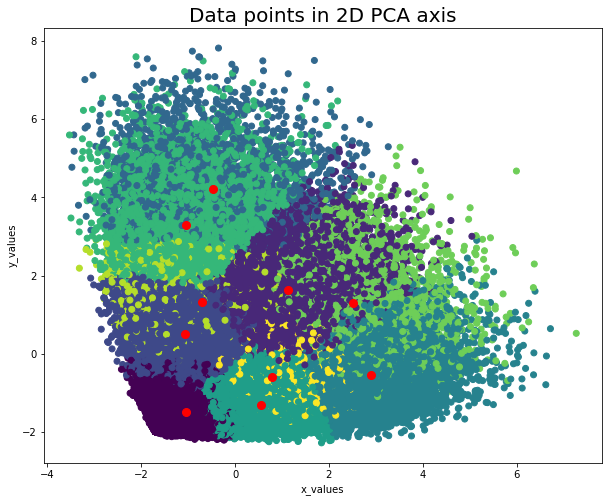

In [105]:
fig = plt.figure(figsize=(10,8))
plt.scatter(users_tocluster[1],users_tocluster[0],c = users_kmeans_sample_preds)
for ci,c in enumerate(users_kmeans_centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

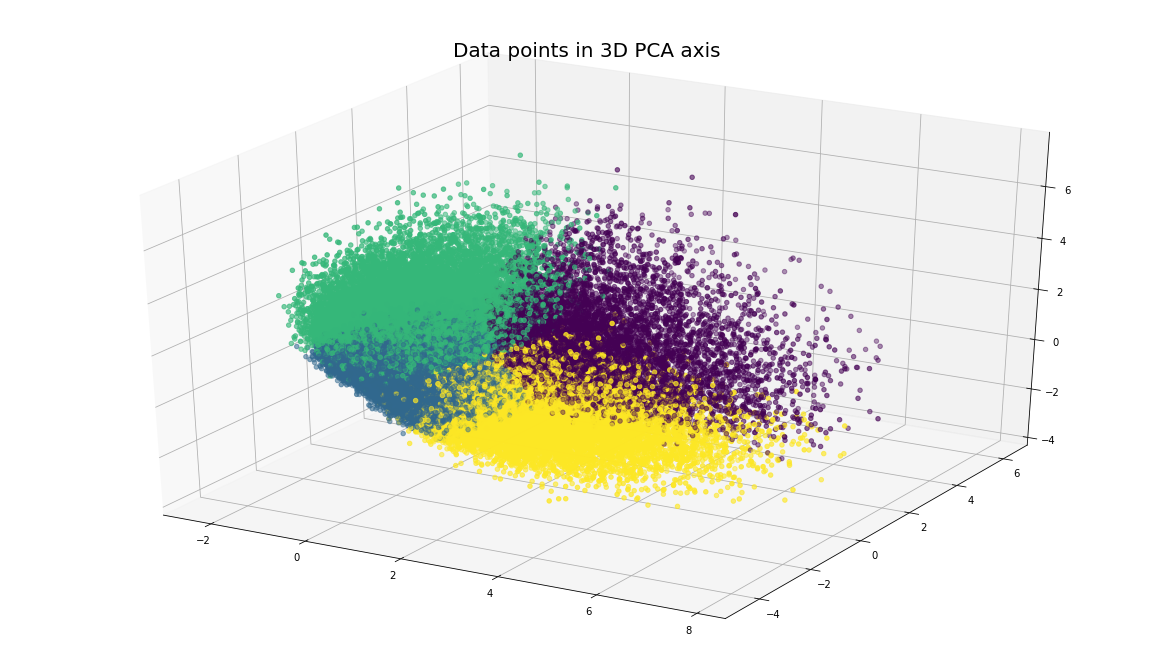

In [106]:
users_kmeans_clusterer_2 = KMeans(n_clusters=4,random_state=30).fit(users_tocluster)
users_kmeans_centers_2 = users_kmeans_clusterer_2.cluster_centers_
users_kmeans_sample_preds_2 = users_kmeans_clusterer_2.predict(users_tocluster)

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(users_tocluster[0], users_tocluster[2], users_tocluster[1], c = users_kmeans_sample_preds_2)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

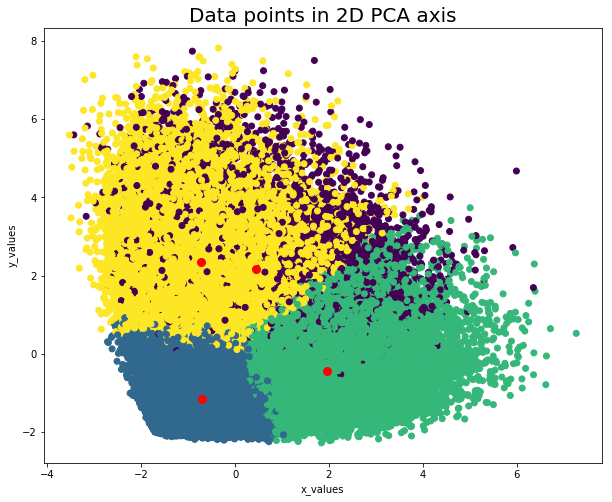

In [107]:
fig = plt.figure(figsize=(10,8))
plt.scatter(users_tocluster[1],users_tocluster[0],c = users_kmeans_sample_preds_2)
for ci,c in enumerate(users_kmeans_centers_2):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

## Recolher informações:


- ### Escolher melhor modelo

Podemos perceber que o modelo GMM não possui um desenpenho muito bom neste data set.

Logo o modelo KMeans é o mais adequado. Quantidade de klusters escolhido foi K =10, pois ele divide melhor os dados mais disperços. Podemos perceber similaridade entre os centros do K=4 e K = 10.

- ### Retirar Informações de cada Kluster

In [109]:
users_features['cluster'] = users_kmeans_sample_preds
c0_count = users_features[users_features['cluster'] == 0]
c0_count.head()

title    "Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi  "Bungaku Shoujo" Memoire  \
user_id                                                                        
112                                            0.0                       0.0   
242                                            0.0                       0.0   
300                                            0.0                       0.0   
501                                            0.0                       0.0   
1004                                           0.0                       0.0   

title    "Bungaku Shoujo" Movie  "Eiji"  "Eiyuu" Kaitai  "Parade" de Satie  \
user_id                                                                      
112                         0.0     0.0             0.0                0.0   
242                         0.0     0.0             0.0                0.0   
300                         0.0     0.0             0.0                0.0   
501                         0.0     0.0             0.0                0.0   
1004                        0.0     0.0             0.0                0.0   

title    (a long day of) Mr. Calpaccio  .hack//G.U. Returner  \
user_id                                                        
112                                0.0                   0.0   
242                                0.0                   0.0   
300                                0.0                   0.0   
501                                0.0                   0.0   
1004                               0.0                   0.0   

title    .hack//G.U. Trilogy  .hack//G.U. Trilogy: Parody Mode   ...     \
user_id                                                          ...      
112                      0.0                               0.0   ...      
242                      0.0                               0.0   ...      
300                      0.0                               0.0   ...      
501                      0.0                               0.0   ...      
1004                     0.0                               0.0   ...      

title    makemagic  s.CRY.ed  vivi  xxxHOLiC  xxxHOLiC Kei  \
user_id                                                      
112            0.0       0.0   0.0       0.0           0.0   
242            0.0       0.0   0.0       0.0           0.0   
300            0.0       0.0   0.0       0.0           0.0   
501            0.0       0.0   0.0       0.0           0.0   
1004           0.0       0.0   0.0       0.0           0.0   

title    xxxHOLiC Movie: Manatsu no Yoru no Yume  xxxHOLiC Shunmuki  ēlDLIVE  \
user_id                                                                        
112                                          0.0                0.0      0.0   
242                                          0.0                0.0      0.0   
300                                          0.0                0.0      0.0   
501                                          0.0                0.0      0.0   
1004                                         0.0                0.0      0.0   

title      ◯  cluster  
user_id                
112      0.0        0  
242      0.0        0  
300      0.0        0  
501      0.0        0  
1004     0.0        0  

[5 rows x 8056 columns]

In [133]:
users_features['gender'] = merge_data['gender']

c0_gender = users_features[users_features['cluster'] == 0].groupby('gender')['gender'].count()
c1_gender = users_features[users_features['cluster'] == 1].groupby('gender')['gender'].count()
c2_gender = users_features[users_features['cluster'] == 2].groupby('gender')['gender'].count()
c3_gender = users_features[users_features['cluster'] == 3].groupby('gender')['gender'].count()
c4_gender = users_features[users_features['cluster'] == 4].groupby('gender')['gender'].count()
c5_gender = users_features[users_features['cluster'] == 5].groupby('gender')['gender'].count()
c6_gender = users_features[users_features['cluster'] == 6].groupby('gender')['gender'].count()
c7_gender = users_features[users_features['cluster'] == 7].groupby('gender')['gender'].count()
c8_gender = users_features[users_features['cluster'] == 8].groupby('gender')['gender'].count()
c9_gender = users_features[users_features['cluster'] == 9].groupby('gender')['gender'].count()



users_cluster_gender = pd.DataFrame(
    {'Cluster 1': c0_gender,
     'Cluster 2': c1_gender,
     'Cluster 3': c2_gender,
     'Cluster 4': c3_gender,
     'Cluster 5': c4_gender,
     'Cluster 6': c5_gender,
     'Cluster 7': c6_gender,
     'Cluster 8': c7_gender, 
     'Cluster 9': c8_gender, 
     'Cluster 10': c9_gender 
    })


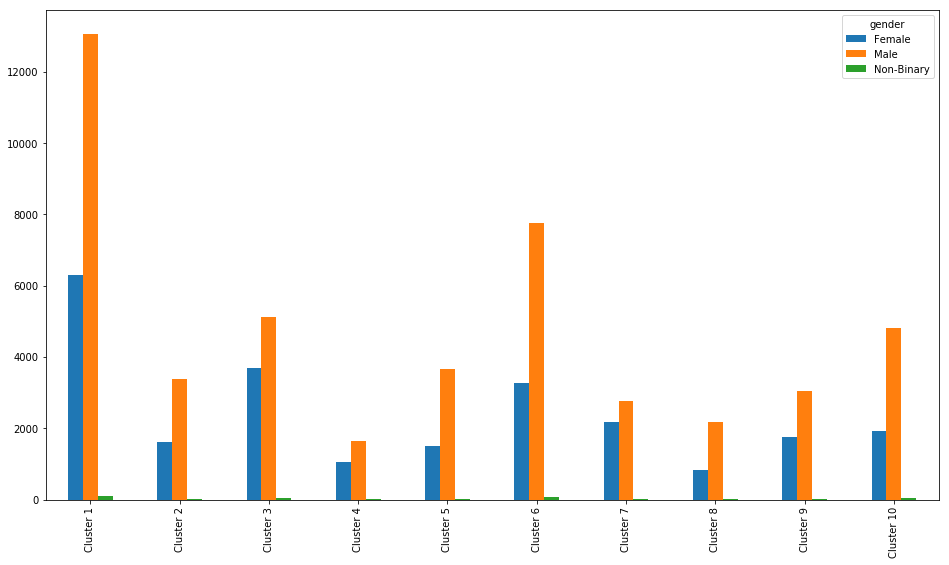

In [134]:
users_cluster_gender = users_cluster_gender.transpose()
users_cluster_gender.plot(kind='bar')

In [114]:
# Retirado do Kernel https://www.kaggle.com/tanetboss/user-clustering-for-anime-recommendation/
def createAnimeInfoList(animelist):
    
    episode_list = list()
    genre_list = list()
    member_list = list()
    score_list= list()
    for x in anime['title']:
        if x in animelist:
           
            episode_list.append(anime[anime['title']==x].episodes.values.astype(int))
            member_list.append(anime[anime['title']==x].members.values.astype(int))
            score_list.append(anime[anime['title']==x].score.values.astype(int))
            for y in anime[anime['title']==x].genre.values:
                 genre_list.append(y)
                    
#    return  genre_list
    return  genre_list,episode_list,score_list,member_list
         
    

def count_word(df, ref_col, liste):
    keyword_count = dict()
    #df[ref_col].apply(lambda x: x.replace(' ', ''))
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(','):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count    

In [115]:
def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

In [121]:
set_keywords = set()
for liste_keywords in data_c0['genre'].str.split(',').values:
    if isinstance(liste_keywords, float): continue  # only happen if liste_keywords = NaN
    set_keywords = set_keywords.union(liste_keywords)    
    

In [135]:
users_features['cluster'] = users_kmeans_sample_preds
c0_users = users_features[users_features['cluster']==0].drop('cluster',axis=1).mean()
c1_users = users_features[users_features['cluster']==1].drop('cluster',axis=1).mean()
c2_users = users_features[users_features['cluster']==2].drop('cluster',axis=1).mean()
c3_users = users_features[users_features['cluster']==3].drop('cluster',axis=1).mean()
c4_users = users_features[users_features['cluster']==4].drop('cluster',axis=1).mean()
c5_users = users_features[users_features['cluster']==5].drop('cluster',axis=1).mean()
c6_users = users_features[users_features['cluster']==6].drop('cluster',axis=1).mean()
c7_users = users_features[users_features['cluster']==7].drop('cluster',axis=1).mean()
c8_users = users_features[users_features['cluster']==8].drop('cluster',axis=1).mean()
c9_users = users_features[users_features['cluster']==9].drop('cluster',axis=1).mean()



In [136]:
animelist_c0 = list(c0_users.sort_values(ascending=False)[0:15].index)
animelist_c1 = list(c1_users.sort_values(ascending=False)[0:15].index)
animelist_c2 = list(c2_users.sort_values(ascending=False)[0:15].index)
animelist_c3 = list(c3_users.sort_values(ascending=False)[0:15].index)
animelist_c4 = list(c4_users.sort_values(ascending=False)[0:15].index)
animelist_c5 = list(c5_users.sort_values(ascending=False)[0:15].index)
animelist_c6 = list(c6_users.sort_values(ascending=False)[0:15].index)
animelist_c7 = list(c7_users.sort_values(ascending=False)[0:15].index)
animelist_c8 = list(c8_users.sort_values(ascending=False)[0:15].index)
animelist_c9 = list(c9_users.sort_values(ascending=False)[0:15].index)


In [137]:
data_c0 = pd.DataFrame()
data_c0['genre'], data_c0['episode'], data_c0['score'], data_c0['member']=  createAnimeInfoList(animelist_c0)
data_c0.iloc[:,1:4] = data_c0.iloc[:,1:4].astype(int)

data_c1 = pd.DataFrame()
data_c1['genre'], data_c1['episode'], data_c1['score'], data_c1['member'] =  createAnimeInfoList(animelist_c1)
data_c1.iloc[:,1:4] = data_c1.iloc[:,1:4].astype(int)

data_c2 = pd.DataFrame()
data_c2['genre'], data_c2['episode'], data_c2['score'], data_c2['member'] =  createAnimeInfoList(animelist_c2)
data_c2.iloc[:,1:4] = data_c2.iloc[:,1:4].astype(int)

data_c3 = pd.DataFrame()
data_c3['genre'], data_c3['episode'], data_c3['score'], data_c3['member'] =  createAnimeInfoList(animelist_c3)
data_c3.iloc[:,1:4] = data_c3.iloc[:,1:4].astype(int)

data_c4 = pd.DataFrame()
data_c4['genre'], data_c4['episode'], data_c4['score'], data_c4['member'] =  createAnimeInfoList(animelist_c4)
data_c4.iloc[:,1:4] = data_c4.iloc[:,1:4].astype(int)

data_c5 = pd.DataFrame()
data_c5['genre'], data_c5['episode'], data_c5['score'], data_c5['member'] =  createAnimeInfoList(animelist_c5)
data_c5.iloc[:,1:4] = data_c5.iloc[:,1:4].astype(int)

data_c6 = pd.DataFrame()
data_c6['genre'], data_c6['episode'], data_c6['score'], data_c6['member'] =  createAnimeInfoList(animelist_c6)
data_c6.iloc[:,1:4] = data_c6.iloc[:,1:4].astype(int)

data_c7 = pd.DataFrame()
data_c7['genre'], data_c7['episode'], data_c7['score'], data_c7['member'] =  createAnimeInfoList(animelist_c7)
data_c7.iloc[:,1:4] = data_c7.iloc[:,1:4].astype(int)

data_c8 = pd.DataFrame()
data_c8['genre'], data_c8['episode'], data_c8['score'], data_c8['member'] =  createAnimeInfoList(animelist_c8)
data_c8.iloc[:,1:4] = data_c8.iloc[:,1:4].astype(int)

data_c9 = pd.DataFrame()
data_c9['genre'], data_c9['episode'], data_c9['score'], data_c9['member'] =  createAnimeInfoList(animelist_c9)
data_c9.iloc[:,1:4] = data_c9.iloc[:,1:4].astype(int)




In [139]:
cluster_info_users = pd.DataFrame(np.array(
    [[data_c0['episode'].mean(), data_c0['score'].mean(),data_c0['member'].mean()],
    [data_c1['episode'].mean(), data_c1['score'].mean(),data_c1['member'].mean()],
    [data_c2['episode'].mean(), data_c2['score'].mean(),data_c2['member'].mean()],
    [data_c3['episode'].mean(), data_c3['score'].mean(),data_c3['member'].mean()],
    [data_c4['episode'].mean(), data_c4['score'].mean(),data_c4['member'].mean()],
    [data_c5['episode'].mean(), data_c5['score'].mean(),data_c5['member'].mean()],
    [data_c6['episode'].mean(), data_c6['score'].mean(),data_c6['member'].mean()],
    [data_c7['episode'].mean(), data_c7['score'].mean(),data_c7['member'].mean()],
    [data_c8['episode'].mean(), data_c8['score'].mean(),data_c8['member'].mean()],
    [data_c9['episode'].mean(), data_c9['score'].mean(),data_c9['member'].mean()]]),
                   columns=['AVG episode ', 'AVG Score', 'AVG Member'])

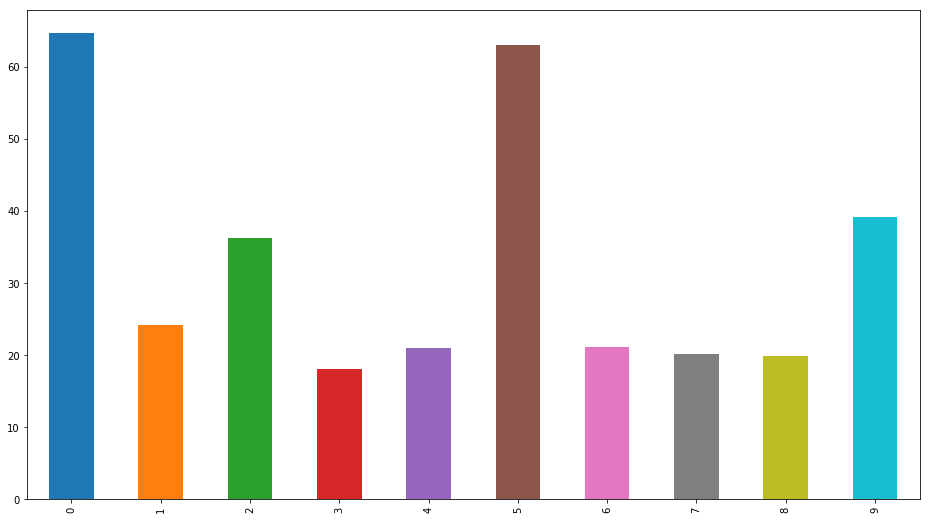

In [140]:
cluster_info_users['AVG episode '].plot.bar()

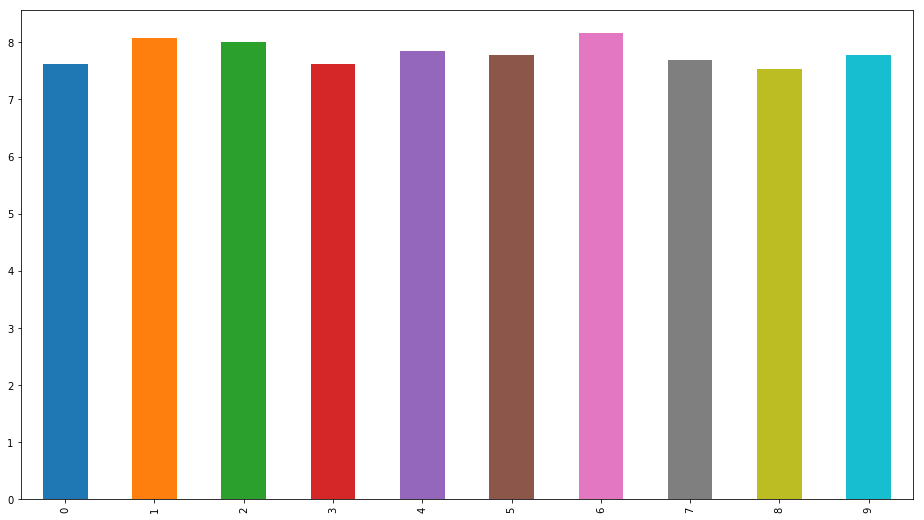

In [141]:
cluster_info_users['AVG Score'].plot.bar()

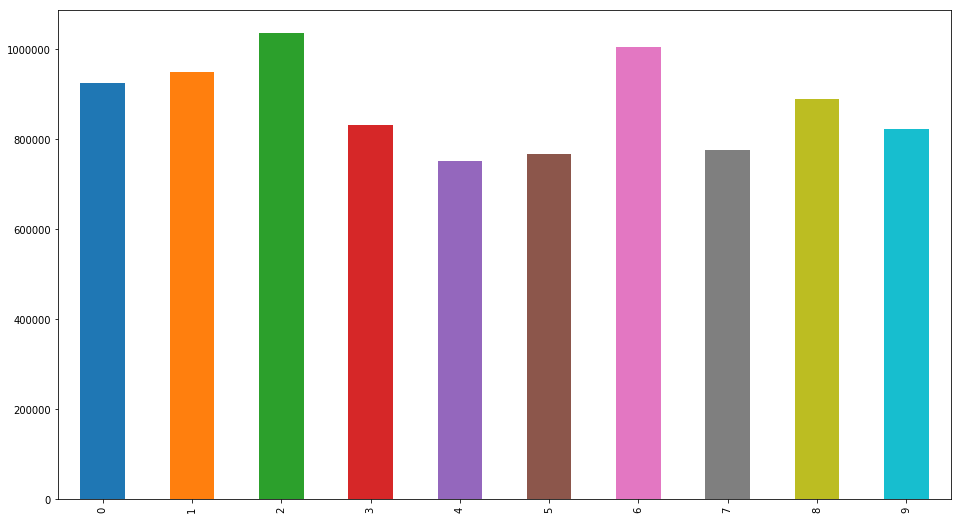

In [142]:
cluster_info_users['AVG Member'].plot.bar()

In [143]:
keyword_occurences_c1, dum = count_word(data_c1, 'genre', set_keywords)

keyword_occurences_c2, dum = count_word(data_c2, 'genre', set_keywords)
keyword_occurences_c3, dum = count_word(data_c3, 'genre', set_keywords)
keyword_occurences_c4, dum = count_word(data_c4, 'genre', set_keywords)
keyword_occurences_c5, dum = count_word(data_c5, 'genre', set_keywords)
keyword_occurences_c6, dum = count_word(data_c6, 'genre', set_keywords)
keyword_occurences_c7, dum = count_word(data_c7, 'genre', set_keywords)
keyword_occurences_c8, dum = count_word(data_c8, 'genre', set_keywords)
keyword_occurences_c9, dum = count_word(data_c9, 'genre', set_keywords)
keyword_occurences_c0, dum = count_word(data_c0, 'genre', set_keywords)


In [144]:
cluster_genre_users = pd.DataFrame({
     'Cluster 1': keyword_occurences_c0,
     'Cluster 2': keyword_occurences_c1,
     'Cluster 3': keyword_occurences_c2,
     'Cluster 4': keyword_occurences_c3,
     'Cluster 5': keyword_occurences_c4,
     'Cluster 6': keyword_occurences_c5,
     'Cluster 7': keyword_occurences_c6, 
     'Cluster 8': keyword_occurences_c7,
     'Cluster 9': keyword_occurences_c8,
     'Cluster 10': keyword_occurences_c9
    })

In [145]:
cluster_genre_users[:10]

Cluster 1          Cluster 2           Cluster 3  \
0        [Action, 8]        [Action, 9]         [Action, 8]   
1         [Drama, 7]         [Drama, 7]   [Supernatural, 7]   
2        [Comedy, 6]     [Adventure, 6]        [Shounen, 6]   
3  [Supernatural, 6]       [Fantasy, 6]          [Drama, 5]   
4       [Shounen, 5]      [Military, 5]         [Comedy, 5]   
5     [Adventure, 5]       [Shounen, 4]      [Adventure, 5]   
6       [Romance, 5]    [SuperPower, 4]        [Mystery, 4]   
7    [SuperPower, 4]        [Sci-Fi, 4]     [SuperPower, 4]   
8        [School, 4]  [Supernatural, 4]        [Fantasy, 4]   
9      [Military, 3]        [Comedy, 3]  [Psychological, 3]   

           Cluster 4          Cluster 5          Cluster 6  \
0        [Comedy, 9]        [Action, 9]        [Action, 9]   
1       [Romance, 8]         [Drama, 8]     [Adventure, 8]   
2        [School, 7]     [Adventure, 7]         [Drama, 7]   
3   [SliceofLife, 5]        [Sci-Fi, 6]        [Comedy, 6]   
4         [Drama, 5]        [Comedy, 5]       [Shounen, 5]   
5        [Action, 4]         [Mecha, 4]  [Supernatural, 4]   
6       [Fantasy, 4]       [Shounen, 3]    [SuperPower, 3]   
7  [Supernatural, 4]      [Military, 3]        [Sci-Fi, 3]   
8          [Game, 2]       [Fantasy, 3]       [Fantasy, 3]   
9       [Shounen, 2]  [Supernatural, 3]       [Romance, 3]   

            Cluster 7          Cluster 8          Cluster 9         Cluster 10  
0         [Action, 7]  [Supernatural, 8]        [Comedy, 8]        [Comedy, 9]  
1   [Supernatural, 7]        [Action, 7]       [Romance, 7]         [Drama, 7]  
2          [Drama, 5]         [Drama, 7]        [School, 7]        [School, 7]  
3        [Shounen, 5]       [Romance, 7]  [Supernatural, 6]        [Action, 6]  
4         [Comedy, 5]        [School, 7]        [Action, 5]   [SliceofLife, 5]  
5        [Fantasy, 5]        [Comedy, 6]   [SliceofLife, 5]  [Supernatural, 5]  
6      [Adventure, 4]   [SliceofLife, 4]         [Drama, 5]       [Romance, 5]  
7        [Mystery, 4]       [Mystery, 3]       [Shounen, 4]       [Shounen, 3]  
8  [Psychological, 4]        [Sci-Fi, 3]       [Mystery, 3]      [Military, 3]  
9     [SuperPower, 3]         [Mecha, 2]       [Fantasy, 3]    [SuperPower, 3]

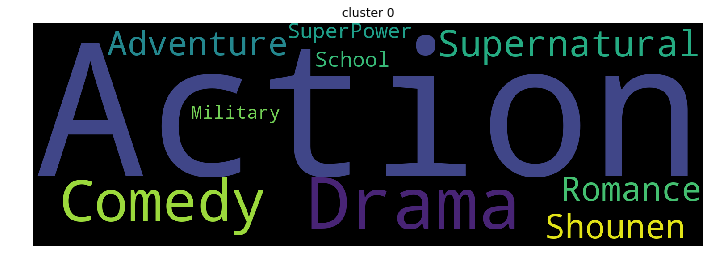

In [147]:
makeCloud(keyword_occurences_c0[0:10],"cluster 0","black")

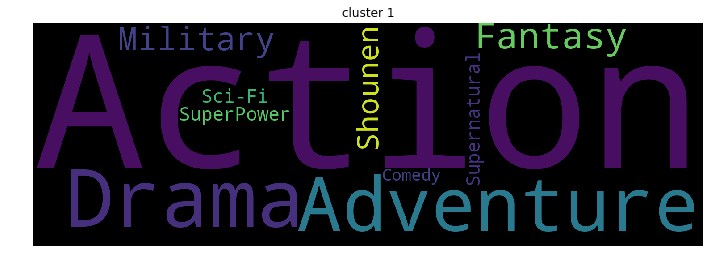

In [148]:
makeCloud(keyword_occurences_c1[0:10],"cluster 1","black")

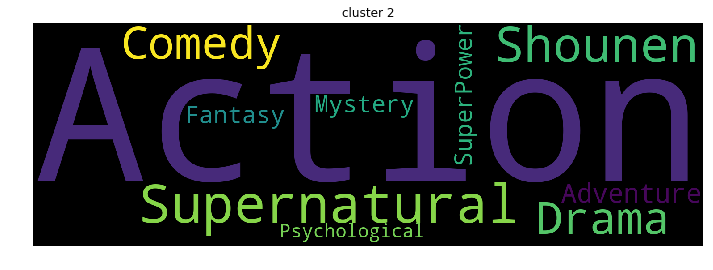

In [149]:
makeCloud(keyword_occurences_c2[0:10],"cluster 2","black")

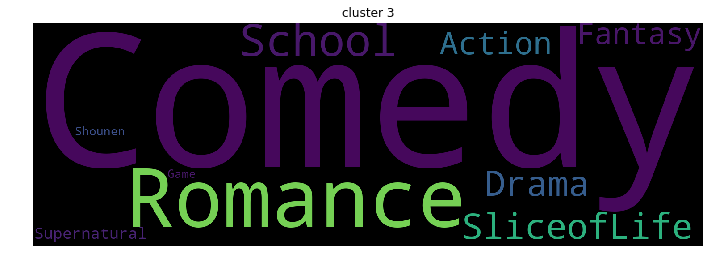

In [150]:
makeCloud(keyword_occurences_c3[0:10],"cluster 3","black")

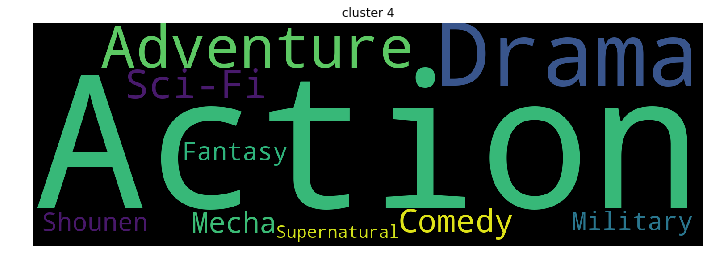

In [151]:
makeCloud(keyword_occurences_c4[0:10],"cluster 4","black")

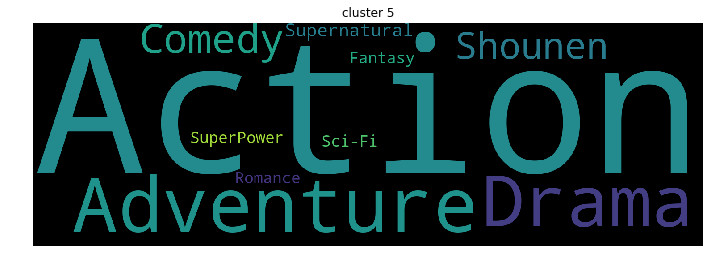

In [152]:
makeCloud(keyword_occurences_c5[0:10],"cluster 5","black")

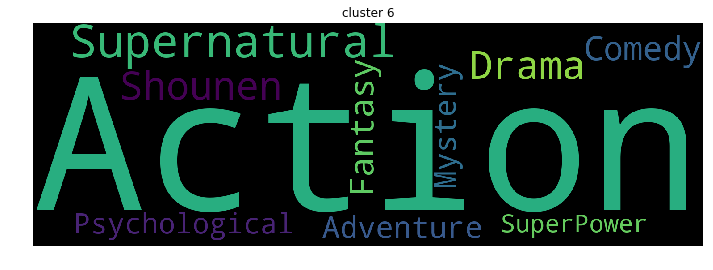

In [153]:
makeCloud(keyword_occurences_c6[0:10],"cluster 6","black")

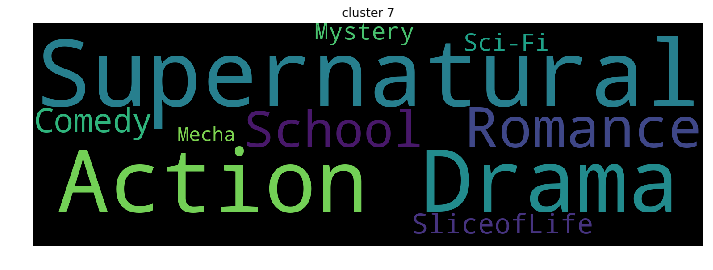

In [154]:
makeCloud(keyword_occurences_c7[0:10],"cluster 7","black")

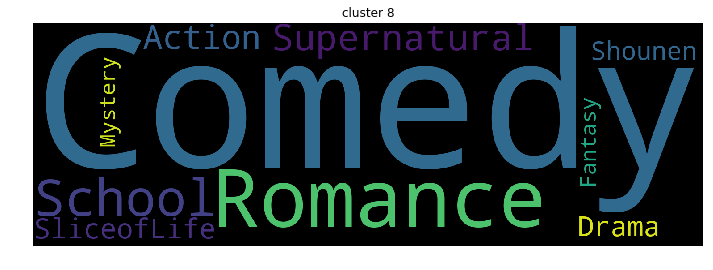

In [155]:
makeCloud(keyword_occurences_c8[0:10],"cluster 8","black")

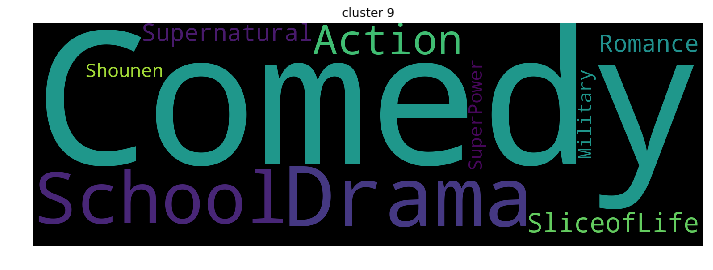

In [156]:
makeCloud(keyword_occurences_c9[0:10],"cluster 9","black")

### Conclusão e Próximos Passos


Estamos lidando com tema subjetivo( Gostar ou não gostar de algo), não existe métricas concretas para serem utilizadas, por isso plataformas como no Netflix, Youtube, entre outros, acaba existindo várias "áreas" com sugestões baseadas em diferentes critérios, como por exemplo:
    - Popularidade
    - Similaridade com a última produção que você assistiu
    - Novidades/ Produtos Novos ou Promoções Pagas
    - Filtro Colaborativo
    - Filtro Demográfico
    - Hibridos
    
Neste trabalho foram criadas 2 dessas "áreas", Filtro Colaborativo e o Filtro Demográfico.  Usamos neste trabalho as métricas BIC e Silhouette Score para o algoritmo  não supervisionado GMM e as métricas "Elbow Method" e Silhouette Score para o algoritmo de não supervisionado Kmeans. 

Essas métricas são apenas para identificar melhor a: quantidade de grupos e seus membros, não para afirmar que o usuário vai gostar do produto apontado.
